In [1]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn import preprocessing
from tqdm.auto import tqdm
import gurobipy as gp
from gurobipy import GRB
from math import sqrt

In [437]:
df_save_all

,std_dev,return,ESG,weights,random_PF
0,NaN,0.977199,6.35258,NaN,0
1,NaN,0.980614,6.35258,NaN,0
2,NaN,0.984029,6.35258,NaN,0
3,NaN,0.987444,6.35258,NaN,0
4,NaN,0.990859,6.35258,NaN,0
...,...,...,...,...,...
39995,NaN,1.643131,93.44809,NaN,0
39996,NaN,1.646546,93.44809,NaN,0
39997,NaN,1.649961,93.44809,NaN,0
39998,NaN,1.653376,93.44809,NaN,0


In [2]:
# Import ESG data
#esg_data=pd.read_csv('TotalESG_2.csv',sep=';',decimal=',')
esg_data=pd.read_csv('TotalESG.csv',sep=';',decimal=',')
# clean ESG data
# Change WAHR and FALSCH
for col in esg_data.columns:
    esg_data[col] = np.where(esg_data[col] == "WAHR",True,esg_data[col])
    esg_data[col] = np.where(esg_data[col] == "FALSCH",False,esg_data[col])
    esg_data[col] = np.where(esg_data[col] == "Unable to collect data for some field(s).",np.nan,esg_data[col])

# drop all columns with only 0 values
esg_data = esg_data.loc[:, (esg_data != 0).any(axis=0)]

#drop TR. from column name
for col in esg_data.columns[2:-1]:
    esg_data.rename(columns={col:col[3:]},inplace=True)

stocks = list(esg_data['RIC'].unique())
esg_data['transparency'] = (961-esg_data.isna().sum(axis=1))/961

#replace NaN

#esg_data.fillna(0,inplace=True)
esg_data

,RIC,Date,AnalyticEnergyUseEVIC,AnalyticWaterUseEVIC,AnalyticElectricityPurchasedPerTonneofAluminumProduction,AnalyticElectricityPurchasedPerTonneofChlorineProduction,AnalyticResourceRedPolicy,PolicyWaterEfficiency,PolicyEnergyEfficiency,PolicySustainablePackaging,...,AnalyticTotalRenewableEnergyScore,AnalyticSeniorExecsTotalCompScore,AnalyticLitigationExpensesScore,InternalCarbonPriceTonneScore,RevenueEnvProductsScore,FossilFuelDivestmentPolicyScore,UNPRISignatoryScore,EmployeeResourceGroupsScore,TR.GenderPayGapPctageScore,transparency
0,CMA.N,31.12.10,NaN,NaN,NaN,NaN,True,True,True,False,...,NaN,32.076446,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.470343
1,CMA.N,31.12.11,NaN,NaN,NaN,NaN,True,True,True,False,...,NaN,20.360825,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.472425
2,CMA.N,31.12.12,NaN,NaN,NaN,NaN,True,True,True,False,...,NaN,33.591331,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.474506
3,CMA.N,31.12.13,NaN,NaN,NaN,NaN,True,True,True,False,...,NaN,43.691830,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.472425
4,CMA.N,31.12.14,NaN,NaN,NaN,NaN,True,True,True,False,...,NaN,30.590062,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.469303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6022,CPT.N,31.12.17,NaN,NaN,NaN,NaN,True,True,True,False,...,NaN,40.218169,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.402706
6023,CPT.N,31.12.18,NaN,NaN,NaN,NaN,True,True,True,False,...,NaN,39.397632,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.422477
6024,CPT.N,31.12.19,NaN,7594.360135,NaN,NaN,True,True,True,False,...,NaN,41.403916,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.462019
6025,CPT.N,31.12.20,NaN,9857.111305,NaN,NaN,True,True,True,False,...,NaN,46.744335,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.502601


In [30]:
#for col in esg_data.columns:
#    print(col)

In [4]:
esg_data[['stock', 'rest']] = esg_data.RIC.str.split(".", expand = True)
esg_data = esg_data[esg_data['Date']=='31.12.21']
filtered_esg = esg_data[['RIC', 'stock', 'TRESGScore', 'transparency']]
filtered_esg.reset_index(inplace=True)
filtered_esg.set_index('stock', inplace=True)
filtered_esg
filtered_esg.rename(columns={'TRESGScore':'ESG'}, inplace=True)
filtered_esg = filtered_esg[filtered_esg['transparency']>0.05]
filtered_esg

,index,RIC,ESG,transparency
stock,,,,
CMA,11,CMA.N,71.325067,0.588970
ZION,23,ZION.OQ,52.030880,0.468262
RF,35,RF.N,82.988872,0.539022
WFC,47,WFC.N,72.306921,0.578564
FITB,59,FITB.OQ,79.692769,0.585848
...,...,...,...,...
UDR,5978,UDR.N,64.613957,0.516129
FRT,5990,FRT.N,80.009772,0.557752
SBAC,6002,SBAC.OQ,72.649211,0.545265


In [6]:
# Import return data
ret = pd.read_excel('returns_feb.xlsx', index_col=0)
ret.drop(columns=['K','CDNS','TXT','AVY','SWK','SNA','AAP'], inplace=True)
means = pd.DataFrame(ret.mean())
means.rename(columns={0:'returns'}, inplace=True)
means

,returns
SHW,0.021069
DTE,0.012325
LOW,0.022589
WBA,0.008585
MAR,0.017571
...,...
CI,0.016464
FIS,0.014962
FTNT,0.026754
TXN,0.018182


In [63]:
ret_trans = ret.drop(columns=intransparent)
ret_trans

,SHW,DTE,LOW,WBA,MAR,EMR,WEC,REG,MS,BLK,...,CHD,EXPE,COP,SNPS,CF,CI,FIS,FTNT,TXN,CTAS
2012-02-01,0.057623,0.014659,0.063383,-0.005995,0.024093,-0.020825,0.002353,0.035576,-0.003159,0.093407,...,0.052237,0.051900,0.122270,0.044566,0.048596,-0.016061,0.110994,0.185883,0.035396,0.039633
2012-03-01,0.057641,0.019263,0.105708,0.016557,0.075981,0.045270,0.041277,0.050942,0.059331,0.029648,...,0.035582,-0.017915,0.001949,0.006236,-0.015891,0.116527,0.043808,0.022181,0.007796,0.014523
2012-04-01,0.106837,0.035550,0.002868,0.046880,0.032761,0.006899,0.047186,0.010791,-0.120164,-0.057879,...,0.032730,0.278918,-0.057624,-0.021200,0.056994,-0.060458,0.022985,-0.055335,-0.049688,0.001278
2012-05-01,0.077819,0.007982,-0.147165,-0.129493,-0.009721,-0.109821,0.027144,-0.025578,-0.224590,-0.108467,...,0.048031,0.075967,-0.044772,-0.015328,-0.114472,-0.050184,-0.026433,-0.186447,-0.103561,-0.057953
2012-06-01,0.024277,0.043990,0.064371,-0.024100,0.016042,0.004108,0.054338,0.096439,0.092066,-0.005737,...,0.046623,0.049593,0.085006,-0.004061,0.135886,0.002049,0.039659,0.092706,0.007374,0.046342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,-0.077150,-0.071714,-0.005052,-0.063777,0.095827,-0.102764,-0.059858,-0.018799,-0.068180,-0.110920,...,-0.010059,0.134256,0.220421,-0.098814,0.236540,-0.054288,-0.047664,-0.073301,0.006809,-0.035831
2021-10-01,0.131841,0.021852,0.152618,-0.000637,0.080559,0.029830,0.021089,0.054968,0.056212,0.129870,...,0.058011,0.003112,0.099159,0.112788,0.017556,0.072139,-0.087169,0.151691,-0.024609,0.137761
2021-11-01,0.046208,-0.044199,0.049849,-0.047214,-0.077865,-0.094526,-0.034755,-0.015197,-0.071064,-0.041178,...,0.023123,-0.020193,-0.052876,0.023471,0.066725,-0.101634,-0.056348,-0.012577,0.032402,-0.025190
2021-12-01,0.064915,0.103378,0.056789,0.175537,0.119816,0.064022,0.125141,0.086675,0.035225,0.012105,...,0.150011,0.121857,0.029232,0.080645,0.173699,0.196613,0.044498,0.082172,-0.020273,0.051996


In [64]:
std_t = pd.DataFrame(ret_trans.std()*sqrt(12))
std_t.rename(columns={0:'std_dev'}, inplace=True)
print(std_t['std_dev'].min())
print(std_t['std_dev'].max())
print(std_t['std_dev'].mean())
print(std_t['std_dev'].median())
print(std_t['std_dev'].std())

0.14414648959807383
0.8534373394497704
0.2632279806722175
0.241703308441076
0.08660949088474439


In [61]:
std = pd.DataFrame(ret.std()*sqrt(12))
std.rename(columns={0:'std_dev'}, inplace=True)
print(std['std_dev'].min())
print(std['std_dev'].max())
print(std['std_dev'].mean())
print(std['std_dev'].median())
print(std['std_dev'].std())


0.14414648959807383
0.8534373394497704
0.2638162416032995
0.2446128142493302
0.08306526250441426


In [7]:
df_new = pd.merge(means, filtered_esg, left_index =True, right_index=True)
df_new.drop(columns=['index', 'RIC'], inplace=True)
df_new['returns'] = (df_new['returns']+1)**12
df_new['returns'].max()
df_new

,returns,ESG,transparency
SHW,1.284286,79.468152,0.595213
DTE,1.158350,82.844435,0.582726
LOW,1.307411,84.502956,0.551509
WBA,1.108031,90.328708,0.592092
MAR,1.232468,75.380882,0.586889
...,...,...,...
CI,1.216476,80.429496,0.560874
FIS,1.195085,69.776147,0.534860
FTNT,1.372760,63.542255,0.500520
TXN,1.241377,85.689298,0.571280


In [686]:
stats.pearsonr(df_new['ESG'], df_new['transparency'])

(0.6629171846503691, 1.9793584643477173e-60)

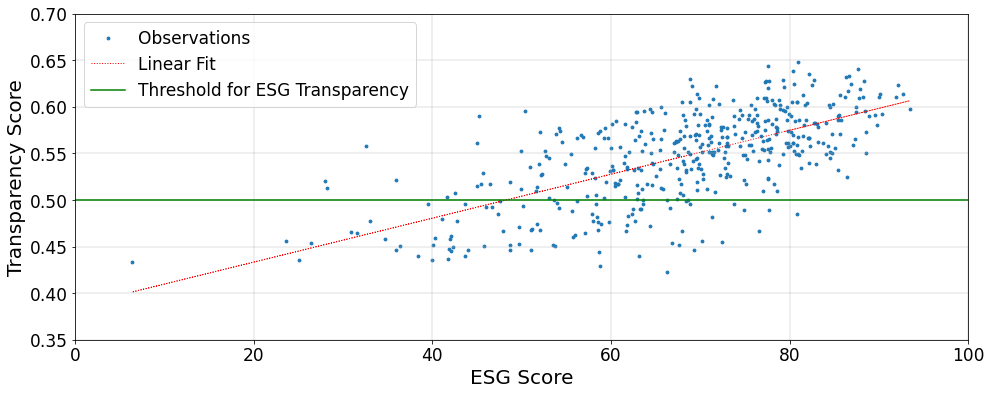

In [673]:
font ={'size':20}


plt.figure(figsize=(16, 6))
plt.scatter(df_new['ESG'], df_new['transparency'],s=8, alpha=1.0, label='Observations')
m, b = np.polyfit(df_new['ESG'],df_new['transparency'], 1)
plt.plot(df_new['ESG'], m*df_new['ESG']+b, color='r', linewidth= 1,linestyle='dotted', label='Linear Fit')
plt.axhline(y=0.5, color='green', linestyle='-', label='Threshold for ESG Transparency')

plt.ylabel('Transparency Score', fontdict=font)
plt.xlabel('ESG Score', fontdict=font)
plt.legend(prop={'size':17})
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

plt.xlim(0, 100)
plt.ylim(0.35, 0.7)

plt.grid(visible=True, linewidth=0.4)
plt.savefig('Transparency_ESG_corr_feb.png', dpi=300, bbox_inches='tight')
#plt.savefig('2D_eff_thesis.png')
#plt.legend()
plt.show()

In [447]:
df_new[df_new['transparency']<0.5]['ESG'].mean()

52.79002941045454

In [449]:
df_new['ESG'].mean()

67.85094694267664

In [53]:
len(df_new.index.values)

467

In [54]:
len(df_trans.index.values)

379

In [56]:
intransparent = []
for stock in df_new.index.values:
    if stock not in df_trans.index.values:
        intransparent.append(stock)

print(len(intransparent))
        

88


In [46]:
# EDA all
print(df_new['returns'].min()-1)
print(df_new['returns'].max()-1)
print(df_new['returns'].mean()-1)
print(df_new['returns'].median()-1)
print(df_new['returns'].std())
print((df_new['returns']-1).std())

-0.022801232324570098
0.656790934232804
0.20282753698808054
0.1938572406719652
0.09303033489881517
0.09303033489881517


In [45]:
print(df_trans['returns'].min()-1)
print(df_trans['returns'].max()-1)
print(df_trans['returns'].mean()-1)
print(df_trans['returns'].median()-1)
print(df_trans['returns'].std())
print((df_trans['returns']-1).std())

-0.022801232324570098
0.656790934232804
0.1927352295175604
0.18142017064449023
0.09049517959772171
0.09049517959772167


In [47]:
print(df_new['ESG'].min())
print(df_new['ESG'].max())
print(df_new['ESG'].mean())
print(df_new['ESG'].median())
print(df_new['ESG'].std())

6.35257557
93.44809187
67.85094694267664
69.67716456
13.775140782938033


In [48]:
print(df_trans['ESG'].min())
print(df_trans['ESG'].max())
print(df_trans['ESG'].mean())
print(df_trans['ESG'].median())
print(df_trans['ESG'].std())
#print((df_trans['ESG']-1).std())

27.99384377
93.44809187
71.34794098709762
72.22154197
11.220437963720885


In [233]:
df_trans = df_new[df_new['transparency']>=0.5]
df_trans

,returns,ESG,transparency,real_return
SHW,1.284286,79.468152,0.595213,28.428564
DTE,1.158350,82.844435,0.582726,15.835033
LOW,1.307411,84.502956,0.551509,30.741147
WBA,1.108031,90.328708,0.592092,10.803119
MAR,1.232468,75.380882,0.586889,23.246769
...,...,...,...,...
CI,1.216476,80.429496,0.560874,21.647567
FIS,1.195085,69.776147,0.534860,19.508458
FTNT,1.372760,63.542255,0.500520,37.276004
TXN,1.241377,85.689298,0.571280,24.137660


In [78]:
df_new['real_return']= (df_new['returns']-1)*100
df_new


,returns,ESG,transparency,real_return
SHW,1.284286,79.468152,0.595213,28.428564
DTE,1.158350,82.844435,0.582726,15.835033
LOW,1.307411,84.502956,0.551509,30.741147
WBA,1.108031,90.328708,0.592092,10.803119
MAR,1.232468,75.380882,0.586889,23.246769
...,...,...,...,...
CI,1.216476,80.429496,0.560874,21.647567
FIS,1.195085,69.776147,0.534860,19.508458
FTNT,1.372760,63.542255,0.500520,37.276004
TXN,1.241377,85.689298,0.571280,24.137660


In [234]:
df_trans['real_return']= (df_trans['returns']-1)*100
df_trans



,returns,ESG,transparency,real_return
SHW,1.284286,79.468152,0.595213,28.428564
DTE,1.158350,82.844435,0.582726,15.835033
LOW,1.307411,84.502956,0.551509,30.741147
WBA,1.108031,90.328708,0.592092,10.803119
MAR,1.232468,75.380882,0.586889,23.246769
...,...,...,...,...
CI,1.216476,80.429496,0.560874,21.647567
FIS,1.195085,69.776147,0.534860,19.508458
FTNT,1.372760,63.542255,0.500520,37.276004
TXN,1.241377,85.689298,0.571280,24.137660


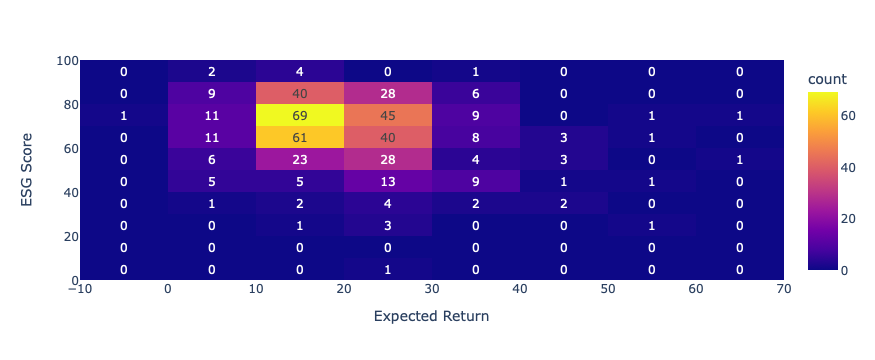

In [85]:
import plotly.express as px
#plt.figsize((9,6))
fig = px.density_heatmap(df_new, x='real_return',y='ESG', text_auto=True, nbinsx=8, nbinsy=10, range_x=[-10,70], range_y=[0,100],labels ={'real_return':'Expected Return','ESG':'ESG Score'})
#fig.tight_layout()
fig.show()


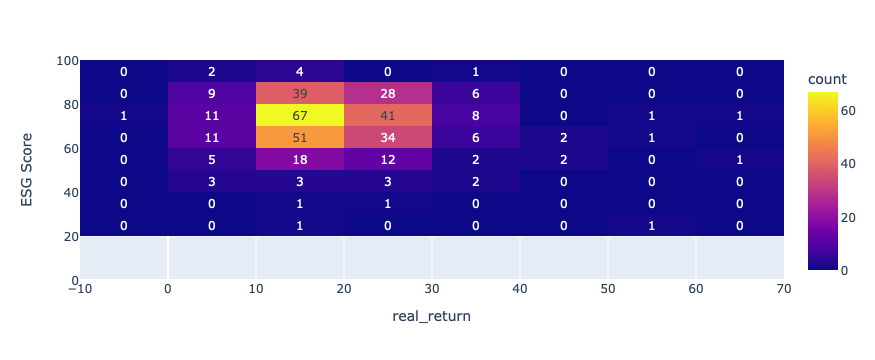

In [83]:
import plotly.express as px
#plt.figsize((9,6))
fig = px.density_heatmap(df_trans, x='real_return',y='ESG', text_auto=True, nbinsx=8, nbinsy=10, range_x=[-10,70], range_y=[0,100],labels ={'returns':'Expected Return','ESG':'ESG Score'})
fig.show()

In [8]:
ret['SHW'].var()*12

0.04637548841285476

In [396]:
sigma = (ret.cov()*12).to_numpy()
len(sigma)

467

In [397]:
ESG_Scores = np.array(df_new['ESG'].round(5))
len(ESG_Scores)

467

In [398]:
mus = np.array(df_new['returns'])
len(mus)

467

# Optimization

In [399]:
# Define ranges
returns_range = np.arange(min(mus), max(mus)+(max(mus)-min(mus))/200, (max(mus)-min(mus))/199)
ESG_range = np.arange(min(ESG_Scores), max(ESG_Scores)+(max(ESG_Scores)-min(ESG_Scores))/200, 
                      (max(ESG_Scores)-min(ESG_Scores))/199)

print(min(mus))
print(max(mus))
print(min(ESG_Scores))
print(max(ESG_Scores))
print(len(returns_range))
print(len(ESG_range))
#print(ESG_range)
#print(ESG_range
#returns_range

0.9771987676754299
1.656790934232804
6.35258
93.44809
200
200


In [400]:
print(len(returns_range))
print(len(ESG_range))
max_ = (len(ESG_range))*(len(returns_range))
print(max_)
counter = 0
efficients = []
weights = []
num_assets = len(mus)
bounds = tuple((0,1) for asset in range(num_assets))
init_guess = num_assets*[1/num_assets]

i = (-1)
frontier = np.empty((4,0))
for target_E in tqdm(ESG_range):
    for target_return in returns_range:
        i = i + 1
        try:
            env = gp.Env(empty=True)
            env.setParam("OutputFlag",0)
            env.start()
            m = gp.Model("mip1", env=env)
            #m = gp.Model("test")
            
            #x = m.addVar(len(mus), lb=-1000, up=1000)
            x = m.addMVar(len(mus),lb=0)
            #x = m.addMVar(len(mus))

            portfolio_return = np.array(mus) @ x

            portfolio_esg = x @ ESG_Scores

            portfolio_risk = x @ sigma @ x

            m.setObjective(portfolio_risk, GRB.MINIMIZE)


            # Fix budget with a constraint
            m.addConstr(x.sum() == 1, 'budget')
            
            # return constraint
            m.addConstr(portfolio_return >= 0.9999*target_return)
            m.addConstr(portfolio_return <= 1.0001*target_return)

            # esg constraint
            m.addConstr(portfolio_esg >= 0.9999*target_E)
            m.addConstr(portfolio_esg <= 1.0001*target_E)

            # Optimize model to find the minimum risk portfolio
            m.optimize()

            #print(portfolio_esg)
            
            res_weights = x.X
            res_weights = np.array(res_weights)
            
            frontier = np.append(frontier, [[sqrt(m.ObjVal)],[np.dot(res_weights,np.array(mus))],[np.dot(res_weights,ESG_Scores)],[res_weights]], axis=1)
            
            
        except:
            frontier = np.append(frontier, [[np.nan],[target_return],[target_E],[np.nan]], axis=1)
            pass

200
200
40000


  0%|          | 0/200 [00:00<?, ?it/s]

In [401]:
a = []
for i in range(frontier.shape[1]):
    a.append(0)


df = pd.DataFrame(frontier)   #, columns = ['Column_A','Column_B','Column_
df = df.transpose()
df = df.set_axis(['std_dev', 'return', 'ESG','weights'], axis=1)
df['random_PF']= a
df['std_dev'].isna().sum()
df

,std_dev,return,ESG,weights,random_PF
0,NaN,0.977199,6.35258,NaN,0
1,NaN,0.980614,6.35258,NaN,0
2,NaN,0.984029,6.35258,NaN,0
3,NaN,0.987444,6.35258,NaN,0
4,NaN,0.990859,6.35258,NaN,0
...,...,...,...,...,...
39995,NaN,1.643131,93.44809,NaN,0
39996,NaN,1.646546,93.44809,NaN,0
39997,NaN,1.649961,93.44809,NaN,0
39998,NaN,1.653376,93.44809,NaN,0


In [404]:
df.to_csv('opt_PF_all.csv')

In [321]:
df_complete = df

In [191]:
df[df['random_PF']!=0]

,std_dev,return,ESG,weights,random_PF


In [106]:
df[df['std_dev']==df['std_dev'].min()]

,std_dev,return,ESG,weights,random_PF
11533,0.074212,1.171973,64.555686,"[1.8333478866027684e-11, 3.418893345342845e-11...",0


In [190]:
df_full_save = df

In [285]:
df_full_save

,index,std_dev,return,ESG,weights,random_PF,uncorr. std,red. by div.,max_weight,ESG_groups,sharp_ratio
0,272,0.458355,1.223204,6.790925,"[1.0065290467690871e-13, 1.0914636054768383e-1...",1,0.461308,0.006401,0.982601,"(6.704, 7.224]",2.668681
1,273,0.456047,1.226374,6.790925,"[2.5178002435125935e-13, 2.408110201750646e-13...",1,0.461362,0.01152,0.978655,"(6.704, 7.224]",2.689141
2,274,0.456483,1.229788,6.790925,"[1.0560934213262875e-12, 1.0073169244054119e-1...",2,0.464993,0.018302,0.979605,"(6.704, 7.224]",2.694053
3,472,0.447479,1.223204,7.228635,"[9.286672328428152e-13, 1.0686153825447811e-12...",1,0.454084,0.014546,0.959088,"(7.224, 7.657]",2.733543
4,473,0.446177,1.226374,7.228635,"[7.141776563693323e-13, 6.820448752691792e-13,...",1,0.455366,0.02018,0.956929,"(7.224, 7.657]",2.748628
...,...,...,...,...,...,...,...,...,...,...,...
27100,39699,0.192304,1.315156,93.001123,"[6.662101869153047e-12, 1.1293764472027148e-11...",0,0.207579,0.073584,0.916298,"(92.572, 93.006]",6.838938
27101,39700,0.194816,1.31857,93.001123,"[7.647429597245509e-11, 1.2967608074410833e-10...",0,0.207908,0.062971,0.929992,"(92.572, 93.006]",6.768284
27102,39701,0.197503,1.321985,93.001123,"[1.528871698578398e-12, 1.6707719574252842e-12...",0,0.208238,0.05155,0.943686,"(92.572, 93.006]",6.693488
27103,39702,0.200358,1.3254,93.001123,"[2.895782445425146e-13, 3.1264833877549083e-13...",0,0.208567,0.039359,0.957380,"(92.572, 93.006]",6.615146


In [408]:
df = df.dropna()
df

,std_dev,return,ESG,weights,random_PF
272,0.458355,1.223204,6.790925,"[1.0065290467690871e-13, 1.0914636054768383e-1...",0
273,0.456047,1.226374,6.790925,"[2.5178002435125935e-13, 2.408110201750646e-13...",0
274,0.456483,1.229788,6.790925,"[1.0560934213262875e-12, 1.0073169244054119e-1...",0
472,0.447479,1.223204,7.228635,"[9.286672328428152e-13, 1.0686153825447811e-12...",0
473,0.446177,1.226374,7.228635,"[7.141776563693323e-13, 6.820448752691792e-13,...",0
...,...,...,...,...,...
39699,0.192304,1.315156,93.001123,"[6.662101869153047e-12, 1.1293764472027148e-11...",0
39700,0.194816,1.31857,93.001123,"[7.647429597245509e-11, 1.2967608074410833e-10...",0
39701,0.197503,1.321985,93.001123,"[1.528871698578398e-12, 1.6707719574252842e-12...",0
39702,0.200358,1.3254,93.001123,"[2.895782445425146e-13, 3.1264833877549083e-13...",0


In [337]:
d_1 =df[df['ESG']<29]
d_1 = d_1[d_1['ESG']>27]
d_1 =d_1[d_1['return']>1.52]
d_1 = d_1[d_1['return']<1.55]
d_1

,std_dev,return,ESG,weights,random_PF,uncorr. std
9959,0.459278,1.520037,27.800988,"[4.727080378157883e-13, 2.589271963611117e-13,...",0,0.491399
9960,0.473506,1.523452,27.800988,"[3.506684659464465e-13, 2.788892600535869e-13,...",0,0.491706
10159,0.443592,1.520037,28.238698,"[1.6867623610818773e-14, 1.313990646268945e-14...",0,0.491380
10160,0.457343,1.523452,28.238698,"[1.4913816993105504e-14, 1.1916282830762636e-1...",0,0.491687
10161,0.471495,1.526867,28.238698,"[7.752172321283916e-12, 6.1823315401059845e-12...",0,0.491994
10162,0.486016,1.530282,28.238698,"[2.9972831823243375e-15, 2.6312775082485924e-1...",0,0.492301
10359,0.42861,1.520037,28.676407,"[4.1661832553394595e-12, 3.1357045901463243e-1...",0,0.491361
10360,0.441826,1.523452,28.676407,"[1.0996974160089575e-13, 7.45378267887952e-14,...",0,0.491668
10361,0.455491,1.526867,28.676407,"[3.008932849431256e-14, 2.3714783828860606e-14...",0,0.491975
10362,0.469565,1.530282,28.676407,"[8.172006166063969e-14, 6.421469132054012e-14,...",0,0.492282


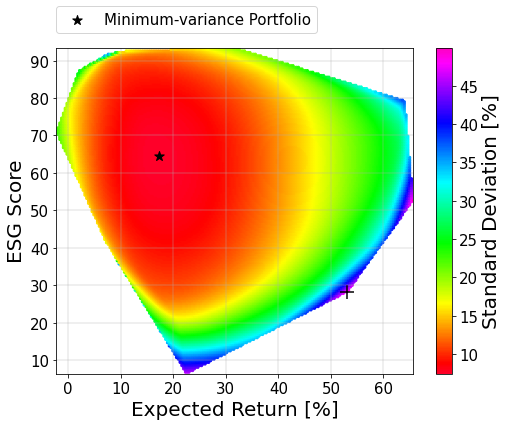

In [343]:
plt.figure(figsize=(8, 6))
plt.scatter(df['return']*100-100,df['ESG'], c = df['std_dev']*100, cmap= 'gist_rainbow', marker='o',s=5, alpha=1.0) #, label = solve_notsolve['solve'])
plt.colorbar(label='Standard Deviation [%]')
#plt.scatter(sdp,rp,marker='*',color='r',s=300, label='Maximum Sharpe Ratio')
plt.scatter(1.171973*100-100,64.56,marker='*',color='black',s=100, label='Minimum-variance Portfolio')
plt.scatter(1.53*100-100,28.3,marker='+',color='black',s=200)
#plt.scatter(sdp_min,rp_min,marker='*',color='g',s=300, label='Minimum volatility')  gist_rainbow
#plt.title('')
plt.ylabel('ESG Score')
plt.xlabel('Expected Return [%]')
plt.legend(bbox_to_anchor =(0.75, 1.15))
#plt.legend()

plt.rcParams.update({'font.size': 15})
plt.rc('axes', labelsize = 20)

plt.xlim(min(mus)*100-100, max(mus)*100-100)
plt.ylim(min(ESG_Scores), max(ESG_Scores))
#plt.ylim(0, 100)
plt.grid(visible=True, linewidth=0.4)
plt.savefig('2D_all_feb.png', dpi=300)
#plt.savefig('2D_eff_thesis.png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


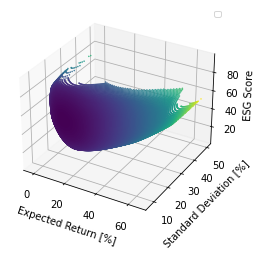

In [347]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()

ax = plt.axes(projection='3d')

y=df['std_dev']*100
x=df['return']*100-100
z=df['ESG']

ax.scatter(x, y, z, c=df['std_dev'], marker='.', alpha = 1.0, s=1.0)

ax.set_xlabel('Expected Return [%]')
ax.set_ylabel('Standard Deviation [%]')
ax.set_zlabel('ESG Score')
ax.zaxis.labelpad=1.5

plt.rcParams.update({'font.size': 10})
plt.rc('axes', labelsize = 10)
#ax.scatter(0.23957*100, 0.06096*100, 62.38, c='red', marker='*', alpha = 1.0, s=100.0, label='Minimum Variance Portfolio')
plt.legend(fontsize=8)
#fig.tight_layout()

plt.savefig('3D_frontier_all_feb', dpi=300, bbox_inches='tight')

plt.show()

In [283]:
opt_results

,index,std_dev,return,ESG,weights,random_PF,uncorr. std,red. by div.,max_weight,ESG_groups,sharp_ratio
0,272,0.458355,1.223204,6.790925,"[1.0065290467690871e-13, 1.0914636054768383e-1...",1,0.461308,0.006401,0.982601,"(6.704, 7.224]",2.668681
1,273,0.456047,1.226374,6.790925,"[2.5178002435125935e-13, 2.408110201750646e-13...",1,0.461362,0.01152,0.978655,"(6.704, 7.224]",2.689141
2,274,0.456483,1.229788,6.790925,"[1.0560934213262875e-12, 1.0073169244054119e-1...",2,0.464993,0.018302,0.979605,"(6.704, 7.224]",2.694053
3,472,0.447479,1.223204,7.228635,"[9.286672328428152e-13, 1.0686153825447811e-12...",1,0.454084,0.014546,0.959088,"(7.224, 7.657]",2.733543
4,473,0.446177,1.226374,7.228635,"[7.141776563693323e-13, 6.820448752691792e-13,...",1,0.455366,0.02018,0.956929,"(7.224, 7.657]",2.748628
...,...,...,...,...,...,...,...,...,...,...,...
27100,39699,0.192304,1.315156,93.001123,"[6.662101869153047e-12, 1.1293764472027148e-11...",0,0.207579,0.073584,0.916298,"(92.572, 93.006]",6.838938
27101,39700,0.194816,1.31857,93.001123,"[7.647429597245509e-11, 1.2967608074410833e-10...",0,0.207908,0.062971,0.929992,"(92.572, 93.006]",6.768284
27102,39701,0.197503,1.321985,93.001123,"[1.528871698578398e-12, 1.6707719574252842e-12...",0,0.208238,0.05155,0.943686,"(92.572, 93.006]",6.693488
27103,39702,0.200358,1.3254,93.001123,"[2.895782445425146e-13, 3.1264833877549083e-13...",0,0.208567,0.039359,0.957380,"(92.572, 93.006]",6.615146


[<matplotlib.lines.Line2D object at 0x7fa9280107c0>, <matplotlib.lines.Line2D object at 0x7fa928010c10>]


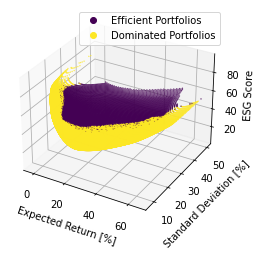

In [414]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax2 = fig.add_subplot(111, projection='3d')

#np.random.seed(19680801)

#a=opt_results_old_2['std_dev']
#b=opt_results_old_2['return'] 
#c=opt_results_old_2['ESG']

#y=opt_results['std_dev'] eigemtlicher dateiname
y=opt_results['std_dev']*100
x=opt_results['return']*100-100
z=opt_results['ESG']



#ax.scatter(a, b, c, marker='.', alpha = 1.0, s=1.0)
sc = ax.scatter(x, y, z, c=opt_results['random_PF'], marker='.', alpha = 1.0, s=0.5) 
#ax.scatter(a, b, c, marker='.', alpha = 1.0, s=1.0)
#ax2.scatter(a, b, c, marker='.', alpha = 1.0, s=1.0)

#ax.grid(b = True, color ='grey', 
#        linestyle ='-.', linewidth = 0.3, 
#        alpha = 0.2)

ax.set_xlabel('Expected Return [%]')
ax.set_ylabel('Standard Deviation [%]')
ax.set_zlabel('ESG Score')
ax.zaxis.labelpad=1.5


#ax.set_box_aspect([1,1,1])
#ax.set_aspect('equal')

plt.rcParams.update({'font.size': 10})
plt.rc('axes', labelsize = 10)

#ax.legend()
#legend1 = ax.legend([opt_results['random_PF']==0, opt_results['random_PF']==1],['Dominated Portfolios','Efficient Portfolios'], title="Legend")

#ax.add_artist(legend1)

#fig.tight_layout()
#plt.savefig('3D_frontier_eff_legend', dpi=300, bbox_inches='tight')
#plt.savefig('3D_frontier_eff.png')
print(sc.legend_elements()[0])

plt.legend([*sc.legend_elements()[0],*sc.legend_elements()[0]], ['Efficient Portfolios', 'Dominated Portfolios'])
plt.savefig('3D_eff+dom_feb', dpi=300, bbox_inches='tight')
plt.show()

In [415]:
opt_results_adj = opt_results[opt_results['random_PF']==0]

In [685]:
opt_results_adj['ESG'].mean()

75.94586329302115

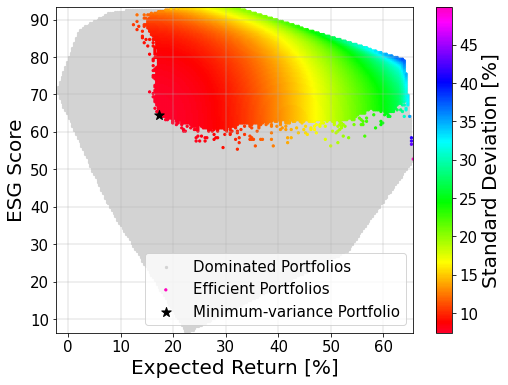

In [418]:
plt.figure(figsize=(8, 6))
plt.scatter(df['return']*100-100,df['ESG'], c = 'lightgray', marker='o',s=5, alpha=1.0, label='Dominated Portfolios') #, label = solve_notsolve['solve'])
plt.scatter(opt_results_adj['return']*100-100,opt_results_adj['ESG'], c = opt_results_adj['std_dev']*100, cmap= 'gist_rainbow', marker='o',s=5, alpha=1.0, label='Efficient Portfolios') #, label = solve_notsolve['solve'])
plt.colorbar(label='Standard Deviation [%]')

plt.scatter(1.171973*100-100,64.555686,marker='*',color='black',s=100, label='Minimum-variance Portfolio')

plt.ylabel('ESG Score')
plt.xlabel('Expected Return [%]')
#plt.legend(['std. dev.'])

plt.rcParams.update({'font.size': 15})
plt.rc('axes', labelsize = 20)

plt.xlim(min(mus)*100-100, max(mus)*100-100)
plt.ylim(6.35, max(ESG_Scores))

plt.grid(visible=True, linewidth=0.4)
plt.legend(loc='lower right')
#plt.legend(bbox_to_anchor =(0.75, 1.15), markerscale=1, fontsize=15)
plt.savefig('2D_all+eff_feb.png', dpi=300)

plt.show()

In [192]:
#df_save = df
df.dropna(inplace=True)
df

,std_dev,return,ESG,weights,random_PF
272,0.458355,1.223204,6.790925,"[1.0065290467690871e-13, 1.0914636054768383e-1...",0
273,0.456047,1.226374,6.790925,"[2.5178002435125935e-13, 2.408110201750646e-13...",0
274,0.456483,1.229788,6.790925,"[1.0560934213262875e-12, 1.0073169244054119e-1...",0
472,0.447479,1.223204,7.228635,"[9.286672328428152e-13, 1.0686153825447811e-12...",0
473,0.446177,1.226374,7.228635,"[7.141776563693323e-13, 6.820448752691792e-13,...",0
...,...,...,...,...,...
39699,0.192304,1.315156,93.001123,"[6.662101869153047e-12, 1.1293764472027148e-11...",0
39700,0.194816,1.31857,93.001123,"[7.647429597245509e-11, 1.2967608074410833e-10...",0
39701,0.197503,1.321985,93.001123,"[1.528871698578398e-12, 1.6707719574252842e-12...",0
39702,0.200358,1.3254,93.001123,"[2.895782445425146e-13, 3.1264833877549083e-13...",0


In [193]:
df.reset_index(inplace=True)
df

,index,std_dev,return,ESG,weights,random_PF
0,272,0.458355,1.223204,6.790925,"[1.0065290467690871e-13, 1.0914636054768383e-1...",0
1,273,0.456047,1.226374,6.790925,"[2.5178002435125935e-13, 2.408110201750646e-13...",0
2,274,0.456483,1.229788,6.790925,"[1.0560934213262875e-12, 1.0073169244054119e-1...",0
3,472,0.447479,1.223204,7.228635,"[9.286672328428152e-13, 1.0686153825447811e-12...",0
4,473,0.446177,1.226374,7.228635,"[7.141776563693323e-13, 6.820448752691792e-13,...",0
...,...,...,...,...,...,...
27100,39699,0.192304,1.315156,93.001123,"[6.662101869153047e-12, 1.1293764472027148e-11...",0
27101,39700,0.194816,1.31857,93.001123,"[7.647429597245509e-11, 1.2967608074410833e-10...",0
27102,39701,0.197503,1.321985,93.001123,"[1.528871698578398e-12, 1.6707719574252842e-12...",0
27103,39702,0.200358,1.3254,93.001123,"[2.895782445425146e-13, 3.1264833877549083e-13...",0


In [411]:
df = df.reset_index()
df

,index,std_dev,return,ESG,weights,random_PF
0,272,0.458355,1.223204,6.790925,"[1.0065290467690871e-13, 1.0914636054768383e-1...",0
1,273,0.456047,1.226374,6.790925,"[2.5178002435125935e-13, 2.408110201750646e-13...",0
2,274,0.456483,1.229788,6.790925,"[1.0560934213262875e-12, 1.0073169244054119e-1...",0
3,472,0.447479,1.223204,7.228635,"[9.286672328428152e-13, 1.0686153825447811e-12...",0
4,473,0.446177,1.226374,7.228635,"[7.141776563693323e-13, 6.820448752691792e-13,...",0
...,...,...,...,...,...,...
27100,39699,0.192304,1.315156,93.001123,"[6.662101869153047e-12, 1.1293764472027148e-11...",0
27101,39700,0.194816,1.31857,93.001123,"[7.647429597245509e-11, 1.2967608074410833e-10...",0
27102,39701,0.197503,1.321985,93.001123,"[1.528871698578398e-12, 1.6707719574252842e-12...",0
27103,39702,0.200358,1.3254,93.001123,"[2.895782445425146e-13, 3.1264833877549083e-13...",0


In [412]:
opt_results = df

for j in tqdm(range(0, len(opt_results))):
    portfolio_std_dev = opt_results["std_dev"][j]
    portfolio_return = opt_results["return"][j]
    portfolio_ESG = opt_results["ESG"][j]
    
    #for k in range(opt_results.min(), len(opt_results)):
    for k in range(0, len(opt_results)):
        if k == j:
            continue
        elif opt_results['random_PF'][k] == 1:
            continue
        else: 
            pf_std_dev_compare = opt_results["std_dev"][k]
            pf_return_compare = opt_results["return"][k]
            pf_ESG_compare = opt_results["ESG"][k]
            if (pf_std_dev_compare <= portfolio_std_dev):
                if (pf_return_compare >= portfolio_return):
                    if (pf_ESG_compare >= portfolio_ESG):
                        opt_results['random_PF'][j] = 1
                        break

  0%|          | 0/27105 [00:00<?, ?it/s]

In [425]:
w = opt_results[opt_results['random_PF']==0]
w

,index,std_dev,return,ESG,weights,random_PF
11499,21399,0.49982,1.656625,52.750438,"[2.8894463759538268e-12, 2.134103506416896e-12...",0
12499,22501,0.099942,1.321985,55.376695,"[1.2374633341633238e-09, 1.849678576239826e-09...",0
12675,22693,0.091366,1.294668,55.814405,"[1.1693672721311817e-09, 1.7844781325406962e-0...",0
12878,22911,0.112577,1.356132,56.252115,"[7.131650463298741e-10, 1.0844327880588246e-09...",0
12888,22921,0.12731,1.390279,56.252115,"[4.7543791189408666e-12, 7.255105694792599e-12...",0
...,...,...,...,...,...,...
27100,39699,0.192304,1.315156,93.001123,"[6.662101869153047e-12, 1.1293764472027148e-11...",0
27101,39700,0.194816,1.31857,93.001123,"[7.647429597245509e-11, 1.2967608074410833e-10...",0
27102,39701,0.197503,1.321985,93.001123,"[1.528871698578398e-12, 1.6707719574252842e-12...",0
27103,39702,0.200358,1.3254,93.001123,"[2.895782445425146e-13, 3.1264833877549083e-13...",0


In [39]:
opt_results_new = opt_results[opt_results['random_PF']==0]
opt_results_new

,index,std_dev,return,ESG,weights,random_PF
3857,8788,0.10525,1.124158,88.624902,"[4.792333245173129e-10, 1.8711891755847697e-09...",0
4149,9185,0.099662,1.130988,87.312036,"[7.497545987931183e-10, 2.81146422561514e-09, ...",0
4154,9190,0.108686,1.130988,89.500146,"[9.116223929410017e-13, 2.894246724905634e-12,...",0
4158,9194,0.121434,1.130988,91.250635,"[2.446549587887294e-10, 5.731435553545352e-10,...",0
4301,9387,0.102336,1.134404,88.18728,"[5.610212121453285e-10, 2.188958780882348e-09,...",0
...,...,...,...,...,...,...
27088,39532,0.351847,1.649796,64.130889,"[2.3796852371248562e-12, 1.7565443677525813e-1...",0
27099,39715,0.431584,1.653211,56.689825,"[1.968905775744275e-13, 1.4035109451865993e-13...",0
27101,39717,0.422637,1.653211,57.565244,"[9.269620128333722e-15, 6.842398031661301e-15,...",0
27103,39719,0.414131,1.653211,58.440663,"[1.8660347012369753e-12, 1.3560222461844858e-1...",0


In [454]:
opt_results_new

,index,std_dev,return,ESG,weights,random_PF,Trans ON
3857,8788,0.10525,1.124158,88.624902,"[4.792333245173129e-10, 1.8711891755847697e-09...",0,0
4149,9185,0.099662,1.130988,87.312036,"[7.497545987931183e-10, 2.81146422561514e-09, ...",0,0
4154,9190,0.108686,1.130988,89.500146,"[9.116223929410017e-13, 2.894246724905634e-12,...",0,0
4158,9194,0.121434,1.130988,91.250635,"[2.446549587887294e-10, 5.731435553545352e-10,...",0,0
4301,9387,0.102336,1.134404,88.18728,"[5.610212121453285e-10, 2.188958780882348e-09,...",0,0
...,...,...,...,...,...,...,...
27088,39532,0.351847,1.649796,64.130889,"[2.3796852371248562e-12, 1.7565443677525813e-1...",0,0
27099,39715,0.431584,1.653211,56.689825,"[1.968905775744275e-13, 1.4035109451865993e-13...",0,0
27101,39717,0.422637,1.653211,57.565244,"[9.269620128333722e-15, 6.842398031661301e-15,...",0,0
27103,39719,0.414131,1.653211,58.440663,"[1.8660347012369753e-12, 1.3560222461844858e-1...",0,0


In [455]:
opt_results_new.to_csv('opt_results_without_rf.csv')

In [459]:
opt_res = opt_results_new.copy()
opt_res

,index,std_dev,return,ESG,weights,random_PF,Trans ON
3857,8788,0.10525,1.124158,88.624902,"[4.792333245173129e-10, 1.8711891755847697e-09...",0,0
4149,9185,0.099662,1.130988,87.312036,"[7.497545987931183e-10, 2.81146422561514e-09, ...",0,0
4154,9190,0.108686,1.130988,89.500146,"[9.116223929410017e-13, 2.894246724905634e-12,...",0,0
4158,9194,0.121434,1.130988,91.250635,"[2.446549587887294e-10, 5.731435553545352e-10,...",0,0
4301,9387,0.102336,1.134404,88.18728,"[5.610212121453285e-10, 2.188958780882348e-09,...",0,0
...,...,...,...,...,...,...,...
27088,39532,0.351847,1.649796,64.130889,"[2.3796852371248562e-12, 1.7565443677525813e-1...",0,0
27099,39715,0.431584,1.653211,56.689825,"[1.968905775744275e-13, 1.4035109451865993e-13...",0,0
27101,39717,0.422637,1.653211,57.565244,"[9.269620128333722e-15, 6.842398031661301e-15,...",0,0
27103,39719,0.414131,1.653211,58.440663,"[1.8660347012369753e-12, 1.3560222461844858e-1...",0,0


In [460]:
opt_res.reset_index(inplace=True)
opt_res

,level_0,index,std_dev,return,ESG,weights,random_PF,Trans ON
0,3857,8788,0.10525,1.124158,88.624902,"[4.792333245173129e-10, 1.8711891755847697e-09...",0,0
1,4149,9185,0.099662,1.130988,87.312036,"[7.497545987931183e-10, 2.81146422561514e-09, ...",0,0
2,4154,9190,0.108686,1.130988,89.500146,"[9.116223929410017e-13, 2.894246724905634e-12,...",0,0
3,4158,9194,0.121434,1.130988,91.250635,"[2.446549587887294e-10, 5.731435553545352e-10,...",0,0
4,4301,9387,0.102336,1.134404,88.18728,"[5.610212121453285e-10, 2.188958780882348e-09,...",0,0
...,...,...,...,...,...,...,...,...
8363,27088,39532,0.351847,1.649796,64.130889,"[2.3796852371248562e-12, 1.7565443677525813e-1...",0,0
8364,27099,39715,0.431584,1.653211,56.689825,"[1.968905775744275e-13, 1.4035109451865993e-13...",0,0
8365,27101,39717,0.422637,1.653211,57.565244,"[9.269620128333722e-15, 6.842398031661301e-15,...",0,0
8366,27103,39719,0.414131,1.653211,58.440663,"[1.8660347012369753e-12, 1.3560222461844858e-1...",0,0


In [461]:
opt_res['ESG_groups'] = pd.cut(opt_res.ESG,50)
opt_res['sharp_ratio'] = (opt_res['return']-1-0.0072)/opt_res['std_dev']
sharps = []
for intervall in opt_res['ESG_groups'].unique():
    #intervall = opt_results['ESG_groups'].unique()[0]
    p = opt_res[opt_res['ESG_groups']==intervall]
    #q = p[p['random_PF']==0]
    i = p[p['sharp_ratio']==p['sharp_ratio'].max()].index[0]
    sharps.append(i)
print(sharps)

for i in sharps:
    opt_res['random_PF'][i] = 2
opt_res

[3410, 3407, 3337, 3341, 3408, 3401, 3476, 3478, 3399, 3263, 3397, 3218, 3537, 3215, 3217, 3377, 3379, 3455, 3457, 3603, 3207, 3211, 3213, 3296, 3298, 3535, 3467, 3468, 3205, 3209, 3300, 3454, 3202, 3204, 3531, 3267, 3200, 3196, 3198, 3197, 3123, 3421, 3271, 3846, 3047, 3346, 4059, 8367]


,level_0,index,std_dev,return,ESG,weights,random_PF,Trans ON,ESG_groups,sharp_ratio
0,3857,8788,0.10525,1.124158,88.624902,"[4.792333245173129e-10, 1.8711891755847697e-09...",0,0,"(88.556, 89.37]",1.11124
1,4149,9185,0.099662,1.130988,87.312036,"[7.497545987931183e-10, 2.81146422561514e-09, ...",0,0,"(86.929, 87.742]",1.242084
2,4154,9190,0.108686,1.130988,89.500146,"[9.116223929410017e-13, 2.894246724905634e-12,...",0,0,"(89.37, 90.184]",1.138952
3,4158,9194,0.121434,1.130988,91.250635,"[2.446549587887294e-10, 5.731435553545352e-10,...",0,0,"(90.997, 91.811]",1.019392
4,4301,9387,0.102336,1.134404,88.18728,"[5.610212121453285e-10, 2.188958780882348e-09,...",0,0,"(87.742, 88.556]",1.242999
...,...,...,...,...,...,...,...,...,...,...
8363,27088,39532,0.351847,1.649796,64.130889,"[2.3796852371248562e-12, 1.7565443677525813e-1...",0,0,"(63.329, 64.143]",1.826353
8364,27099,39715,0.431584,1.653211,56.689825,"[1.968905775744275e-13, 1.4035109451865993e-13...",0,0,"(56.006, 56.819]",1.496838
8365,27101,39717,0.422637,1.653211,57.565244,"[9.269620128333722e-15, 6.842398031661301e-15,...",0,0,"(56.819, 57.633]",1.528525
8366,27103,39719,0.414131,1.653211,58.440663,"[1.8660347012369753e-12, 1.3560222461844858e-1...",0,0,"(57.633, 58.447]",1.559918


[<matplotlib.lines.Line2D object at 0x7fa954d5b700>, <matplotlib.lines.Line2D object at 0x7fa954d5b040>]


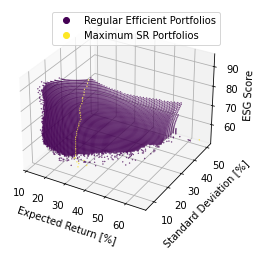

In [465]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

y=opt_res['std_dev']*100
x=opt_res['return']*100-100
z=opt_res['ESG']

sc = ax.scatter(x, y, z, c=opt_res['random_PF'], marker='.', alpha = 1.0, s=0.5) 

ax.set_xlabel('Expected Return [%]')
ax.set_ylabel('Standard Deviation [%]')
ax.set_zlabel('ESG Score')
ax.zaxis.labelpad=1.5

plt.rcParams.update({'font.size': 10})
plt.rc('axes', labelsize = 10)

print(sc.legend_elements()[0])

plt.legend([*sc.legend_elements()[0],*sc.legend_elements()[0]], ['Regular Efficient Portfolios', 'Maximum SR Portfolios'])
plt.savefig('eff_frontier+sharp_feb', dpi=300, bbox_inches='tight')
plt.show()

# Risk free analysis

In [503]:
rf = opt_res
#rf.drop(labels = 'index', inplace = True, axis = 1)
#rf.reset_index(inplace=True)

#rf.drop(columns=['index', 'level_0'], inplace = True, axis = 1)
rf

,std_dev,return,ESG,weights,random_PF,Trans ON,ESG_groups,sharp_ratio,return_sc,ESG_sc
0,0.10525,0.124158,88.624902,"[4.792333245173129e-10, 1.8711891755847697e-09...",0,0,"(88.556, 89.37]",1.11124,0.0,0.88169
1,0.099662,0.130988,87.312036,"[7.497545987931183e-10, 2.81146422561514e-09, ...",0,0,"(86.929, 87.742]",1.242084,0.012828,0.849423
2,0.108686,0.130988,89.500146,"[9.116223929410017e-13, 2.894246724905634e-12,...",0,0,"(89.37, 90.184]",1.138952,0.012828,0.903201
3,0.121434,0.130988,91.250635,"[2.446549587887294e-10, 5.731435553545352e-10,...",0,0,"(90.997, 91.811]",1.019392,0.012828,0.946223
4,0.102336,0.134404,88.18728,"[5.610212121453285e-10, 2.188958780882348e-09,...",0,0,"(87.742, 88.556]",1.242999,0.019243,0.870934
...,...,...,...,...,...,...,...,...,...,...
8363,0.351847,0.649796,64.130889,"[2.3796852371248562e-12, 1.7565443677525813e-1...",0,0,"(63.329, 64.143]",1.826353,0.987174,0.279698
8364,0.431584,0.653211,56.689825,"[1.968905775744275e-13, 1.4035109451865993e-13...",0,0,"(56.006, 56.819]",1.496838,0.993587,0.096819
8365,0.422637,0.653211,57.565244,"[9.269620128333722e-15, 6.842398031661301e-15,...",0,0,"(56.819, 57.633]",1.528525,0.993587,0.118334
8366,0.414131,0.653211,58.440663,"[1.8660347012369753e-12, 1.3560222461844858e-1...",0,0,"(57.633, 58.447]",1.559918,0.993587,0.139849


In [468]:
rf['return'] = rf['return']-1
rf

,std_dev,return,ESG,weights,random_PF,Trans ON,ESG_groups,sharp_ratio
0,0.10525,0.124158,88.624902,"[4.792333245173129e-10, 1.8711891755847697e-09...",0,0,"(88.556, 89.37]",1.11124
1,0.099662,0.130988,87.312036,"[7.497545987931183e-10, 2.81146422561514e-09, ...",0,0,"(86.929, 87.742]",1.242084
2,0.108686,0.130988,89.500146,"[9.116223929410017e-13, 2.894246724905634e-12,...",0,0,"(89.37, 90.184]",1.138952
3,0.121434,0.130988,91.250635,"[2.446549587887294e-10, 5.731435553545352e-10,...",0,0,"(90.997, 91.811]",1.019392
4,0.102336,0.134404,88.18728,"[5.610212121453285e-10, 2.188958780882348e-09,...",0,0,"(87.742, 88.556]",1.242999
...,...,...,...,...,...,...,...,...
8363,0.351847,0.649796,64.130889,"[2.3796852371248562e-12, 1.7565443677525813e-1...",0,0,"(63.329, 64.143]",1.826353
8364,0.431584,0.653211,56.689825,"[1.968905775744275e-13, 1.4035109451865993e-13...",0,0,"(56.006, 56.819]",1.496838
8365,0.422637,0.653211,57.565244,"[9.269620128333722e-15, 6.842398031661301e-15,...",0,0,"(56.819, 57.633]",1.528525
8366,0.414131,0.653211,58.440663,"[1.8660347012369753e-12, 1.3560222461844858e-1...",0,0,"(57.633, 58.447]",1.559918


In [504]:
# Standard Scaling of ESG score and return
rf['return_sc']=(rf['return']-rf['return'].min())/(rf['return'].max()-rf['return'].min())
rf['ESG_sc']=(rf['ESG']-rf['ESG'].min())/(rf['ESG'].max()-rf['ESG'].min())
rf

,std_dev,return,ESG,weights,random_PF,Trans ON,ESG_groups,sharp_ratio,return_sc,ESG_sc
0,0.10525,0.124158,88.624902,"[4.792333245173129e-10, 1.8711891755847697e-09...",0,0,"(88.556, 89.37]",1.11124,0.0,0.88169
1,0.099662,0.130988,87.312036,"[7.497545987931183e-10, 2.81146422561514e-09, ...",0,0,"(86.929, 87.742]",1.242084,0.012828,0.849423
2,0.108686,0.130988,89.500146,"[9.116223929410017e-13, 2.894246724905634e-12,...",0,0,"(89.37, 90.184]",1.138952,0.012828,0.903201
3,0.121434,0.130988,91.250635,"[2.446549587887294e-10, 5.731435553545352e-10,...",0,0,"(90.997, 91.811]",1.019392,0.012828,0.946223
4,0.102336,0.134404,88.18728,"[5.610212121453285e-10, 2.188958780882348e-09,...",0,0,"(87.742, 88.556]",1.242999,0.019243,0.870934
...,...,...,...,...,...,...,...,...,...,...
8363,0.351847,0.649796,64.130889,"[2.3796852371248562e-12, 1.7565443677525813e-1...",0,0,"(63.329, 64.143]",1.826353,0.987174,0.279698
8364,0.431584,0.653211,56.689825,"[1.968905775744275e-13, 1.4035109451865993e-13...",0,0,"(56.006, 56.819]",1.496838,0.993587,0.096819
8365,0.422637,0.653211,57.565244,"[9.269620128333722e-15, 6.842398031661301e-15,...",0,0,"(56.819, 57.633]",1.528525,0.993587,0.118334
8366,0.414131,0.653211,58.440663,"[1.8660347012369753e-12, 1.3560222461844858e-1...",0,0,"(57.633, 58.447]",1.559918,0.993587,0.139849


In [649]:
len(rf[rf['random_PF']==2])

48

In [471]:
import math

In [681]:
#Create a dataframe with enough rows to store the linear combinations
results_rf = pd.DataFrame(columns=["std_dev", 'return', 'ESG', 'random_PF','share_rf', 'max_sharp'], index = range(0,2006000))
results_rf

,std_dev,return,ESG,random_PF,share_rf,max_sharp
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2005995,NaN,NaN,NaN,NaN,NaN,NaN
2005996,NaN,NaN,NaN,NaN,NaN,NaN
2005997,NaN,NaN,NaN,NaN,NaN,NaN
2005998,NaN,NaN,NaN,NaN,NaN,NaN


In [682]:
risk_free = 0.0072
risk_free_sc = (risk_free-rf['return'].min())/(rf['return'].max()-rf['return'].min())
print(risk_free_sc)
ESG_sc=(59-rf['ESG'].min())/(rf['ESG'].max()-rf['ESG'].min())
print(ESG_sc)




-0.2196523030920279
0.15359602395048472


In [683]:
p = 0
for k in tqdm(range(0, len(rf))):
    t_range = np.arange(0, 1+1/(50*math.ceil((sqrt((((rf['return_sc'][k])+0.2197)**2+(rf['ESG_sc'][k]-0.1536)**2))))), (1/(50*math.ceil((sqrt((((rf['return_sc'][k]+0.2197))**2+(rf['ESG_sc'][k]-0.1536)**2)))))))
    if k == 0:
        print(t_range)
    for t in t_range:
        results_rf['std_dev'][p] = (rf['std_dev'][k]) - (t*rf['std_dev'][k])
        results_rf['return'][p] = (rf['return'][k]) - t*(rf['return'][k] - risk_free)
        results_rf['ESG'][p] = (rf['ESG'][k]) - t*(rf['ESG'][k]-59)
        results_rf['random_PF'][p] = 0
        results_rf['share_rf'][p] = t
        results_rf['max_sharp'][p] = rf['random_PF'][k]
        p = p + 1
results_rf

  0%|          | 0/8368 [00:00<?, ?it/s]

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


,std_dev,return,ESG,random_PF,share_rf,max_sharp
0,0.10525,0.124158,88.624902,0,0.0,0
1,0.103145,0.121819,88.032404,0,0.02,0
2,0.10104,0.119479,87.439906,0,0.04,0
3,0.098935,0.11714,86.847408,0,0.06,0
4,0.09683,0.114801,86.25491,0,0.08,0
...,...,...,...,...,...,...
2005995,NaN,NaN,NaN,NaN,NaN,NaN
2005996,NaN,NaN,NaN,NaN,NaN,NaN
2005997,NaN,NaN,NaN,NaN,NaN,NaN
2005998,NaN,NaN,NaN,NaN,NaN,NaN


In [603]:
save_res_10 = results_rf
results_rf.dropna(subset=['std_dev'], inplace=True)
results_rf



,std_dev,return,ESG,random_PF,share_rf,max_sharp
0,0.10525,0.124158,88.624902,0,0.0,0
1,0.104197,0.122988,87.838653,0,0.01,0
2,0.103145,0.121819,87.052404,0,0.02,0
3,0.102092,0.120649,86.266155,0,0.03,0
4,0.10104,0.119479,85.479906,0,0.04,0
...,...,...,...,...,...,...
906863,0.019993,0.033177,11.710018,0,0.96,2
906864,0.014995,0.026683,11.282513,0,0.97,2
906865,0.009996,0.020189,10.855009,0,0.98,2
906866,0.004998,0.013694,10.427504,0,0.99,2


In [680]:
save_res_59

NameError: name 'save_res_59' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


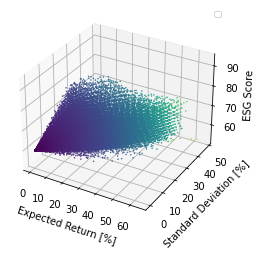

In [477]:
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = plt.axes(projection='3d')

y=results_rf_2['std_dev']*100
x=results_rf_2['return']*100
z=results_rf_2['ESG']

ax.scatter(x, y, z, c=results_rf_2['std_dev'],marker='.', alpha = 1.0, s=1.0)

ax.set_xlabel('Expected Return [%]')
ax.set_ylabel('Standard Deviation [%]')
ax.set_zlabel('ESG Score')
ax.zaxis.labelpad=1.5

plt.rcParams.update({'font.size': 10})
plt.rc('axes', labelsize = 10)
#ax.scatter(0.23957*100, 0.06096*100, 62.38, c='red', marker='*', alpha = 1.0, s=100.0, label='Minimum Variance Portfolio')
plt.legend(fontsize=8)
#fig.tight_layout()

#plt.savefig('3D_frontier_all_final', dpi=300, bbox_inches='tight')
#plt.savefig('3D_frontier_eff.png')

plt.show()

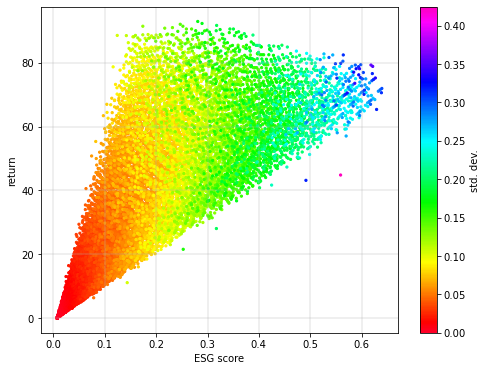

In [515]:
plt.figure(figsize=(8, 6))
plt.scatter(results_rf_2['return'], results_rf_2['ESG'], c = results_rf_2['std_dev'], cmap= 'gist_rainbow', marker='o',s=5, alpha=1.0) #, label = solve_notsolve['solve'])
plt.colorbar(label='std. dev.')

plt.xlabel('ESG score')
plt.ylabel('return')
#plt.legend(['std. dev.'])

#plt.xlim(55, 100)
#plt.ylim(0, max(mus))

plt.grid(visible=True, linewidth=0.4)
#plt.savefig('2D_eff_thesis.png')
plt.show()

In [605]:
results_rf_2 = results_rf[results_rf.index % 32 == 0]
results_rf_2.reset_index(inplace=True)
#results_rf_2 = results_rf_2[results_rf_2.index % 2 != 0]
#results_rf_2.reset_index(inplace=True)
#results_rf_2.drop(labels = ['index','level_0'], inplace = True, axis = 1)
#results_rf_2 = results_rf_2[results_rf_2.index % 2 != 0]
#results_rf_2.reset_index(inplace=True)
#results_rf_2 = results_rf_2[results_rf_2.index % 2 != 0]
#results_rf_2.reset_index(inplace=True)
#results_rf_2 = results_rf_2[results_rf_2.index % 2 != 0]
#results_rf_2.reset_index(inplace=True)
#results_rf_2.drop(labels = ['index','level_0'], inplace = True, axis = 1)
#results_rf_2.reset_index(inplace=True)
results_rf_2



,index,std_dev,return,ESG,random_PF,share_rf,max_sharp
0,0,0.10525,0.124158,88.624902,0,0.0,0
1,32,0.07157,0.086731,63.464933,0,0.32,0
2,64,0.03789,0.049305,38.304965,0,0.64,0
3,96,0.00421,0.011878,13.144996,0,0.96,0
4,128,0.072753,0.097566,66.437786,0,0.27,0
...,...,...,...,...,...,...,...
28335,906720,0.1905,0.304365,32.282705,0,0.54,0
28336,906752,0.057978,0.097641,16.781693,0,0.86,0
28337,906784,0.41485,0.546223,45.482863,0,0.17,2
28338,906816,0.254908,0.338407,31.802723,0,0.49,2


In [606]:
results_rf_2 = results_rf_2[results_rf_2.index % 3 != 0]
results_rf_2.reset_index(inplace=True)
results_rf_2

,level_0,index,std_dev,return,ESG,random_PF,share_rf,max_sharp
0,1,32,0.07157,0.086731,63.464933,0,0.32,0
1,2,64,0.03789,0.049305,38.304965,0,0.64,0
2,4,128,0.072753,0.097566,66.437786,0,0.27,0
3,5,160,0.040861,0.057953,41.697935,0,0.59,0
4,7,224,0.084775,0.103755,72.010114,0,0.22,0
...,...,...,...,...,...,...,...,...
18888,28333,906656,0.038037,0.065341,14.280872,0,0.91,0
18889,28334,906688,0.323022,0.511088,47.783717,0,0.22,0
18890,28336,906752,0.057978,0.097641,16.781693,0,0.86,0
18891,28337,906784,0.41485,0.546223,45.482863,0,0.17,2


In [607]:
opt_results_rf = results_rf_2

for j in tqdm(range(0, len(opt_results_rf))):
    portfolio_std_dev = opt_results_rf["std_dev"][j]
    portfolio_return = opt_results_rf["return"][j]
    portfolio_ESG = opt_results_rf["ESG"][j]
    
    #for k in range(opt_results.min(), len(opt_results)):
    for k in range(0, len(opt_results_rf)):
        if k == j:
            continue
        elif opt_results_rf['random_PF'][k] == 1:
            continue
        else: 
            pf_std_dev_compare = opt_results_rf["std_dev"][k]
            pf_return_compare = opt_results_rf["return"][k]
            pf_ESG_compare = opt_results_rf["ESG"][k]
            if (pf_std_dev_compare <= portfolio_std_dev):
                if (pf_return_compare >= portfolio_return):
                    if (pf_ESG_compare >= portfolio_ESG):
                        opt_results_rf['random_PF'][j] = 1
                        break
                        #opt_results.drop(index=opt_results.index[j], axis=0, inplace=True)

  0%|          | 0/18893 [00:00<?, ?it/s]

In [489]:
ko = opt_results_rf[opt_results_rf['random_PF']==0]
ko

,index,std_dev,return,ESG,random_PF,share_rf,max_sharp
0,1,0.039995,0.051644,70.542663,0,0.62,0
1,3,0.075743,0.101279,80.627547,0,0.24,0
2,5,0.011959,0.022055,62.802244,0,0.88,0
6,13,0.063448,0.086066,77.270914,0,0.38,0
8,17,0.033786,0.055452,68.699013,0,0.64,0
...,...,...,...,...,...,...,...
16318,32637,0.363004,0.636137,78.997215,0,0.0,0
16337,32675,0.293332,0.626905,68.742469,0,0.02,0
16378,32757,0.318242,0.633228,74.469384,0,0.01,0
16419,32839,0.311361,0.642966,68.507985,0,0.0,0


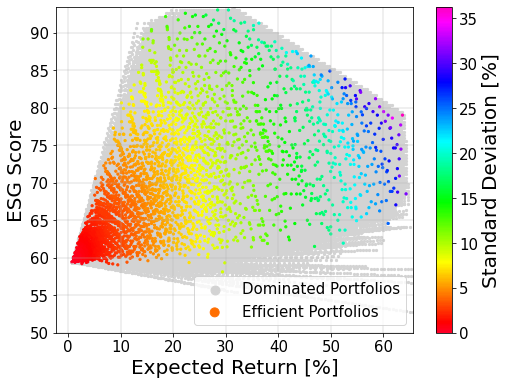

In [493]:
plt.figure(figsize=(8, 6))
plt.scatter(results_rf['return']*100,results_rf['ESG'], c = 'lightgray', marker='o',s=5, alpha=1.0, label='Dominated Portfolios') #, label = solve_notsolve['solve'])
plt.scatter(ko['return']*100,ko['ESG'], c = ko['std_dev']*100, cmap= 'gist_rainbow', marker='o',s=5, alpha=1.0, label='Efficient Portfolios') #, label = solve_notsolve['solve'])
plt.colorbar(label='Standard Deviation [%]')

#plt.scatter(1.171973*100-100,64.555686,marker='*',color='black',s=100, label='Minimum-variance Portfolio')

plt.ylabel('ESG Score')
plt.xlabel('Expected Return [%]')
#plt.legend(['std. dev.'])

plt.rcParams.update({'font.size': 15})
plt.rc('axes', labelsize = 20)

plt.xlim(min(mus)*100-100, max(mus)*100-100)
plt.ylim(50, max(ESG_Scores))

plt.grid(visible=True, linewidth=0.4)
plt.legend(loc='lower right', markerscale=4)
#plt.legend(bbox_to_anchor =(0.75, 1.15), markerscale=1, fontsize=15)
plt.savefig('2d_rf_59_feb.png', dpi=300)

plt.show()

[<matplotlib.lines.Line2D object at 0x7fa8e0d13df0>, <matplotlib.lines.Line2D object at 0x7fa8e0d13ee0>]


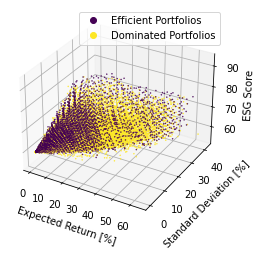

In [497]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

y=opt_results_rf['std_dev']*100
x=opt_results_rf['return']*100 
z=opt_results_rf['ESG']


sc = ax.scatter(x, y, z, c=opt_results_rf['random_PF'], marker='.', alpha = 1, s=0.9)

ax.set_xlabel('Expected Return [%]')
ax.set_ylabel('Standard Deviation [%]')
ax.set_zlabel('ESG Score')
ax.zaxis.labelpad=1.5

plt.rcParams.update({'font.size': 10})
plt.rc('axes', labelsize = 10)

print(sc.legend_elements()[0])

plt.legend([*sc.legend_elements()[0],*sc.legend_elements()[0]], ['Efficient Portfolios', 'Dominated Portfolios'])
plt.savefig('3D_rf_59_feb', dpi=300, bbox_inches='tight')
plt.show()

In [499]:
opt_results_rf

,index,std_dev,return,ESG,random_PF,share_rf,max_sharp
0,1,0.039995,0.051644,70.542663,0,0.62,0
1,3,0.075743,0.101279,80.627547,0,0.24,0
2,5,0.011959,0.022055,62.802244,0,0.88,0
3,7,0.054343,0.069094,74.480073,1,0.5,0
4,9,0.106862,0.116134,87.435758,1,0.12,0
...,...,...,...,...,...,...,...
16506,33013,0.178076,0.284985,59.021685,1,0.57,0
16507,33015,0.045554,0.078261,59.347873,1,0.89,0
16508,33017,0.399856,0.52674,54.09235,1,0.2,2
16509,33019,0.239914,0.318924,56.23941,1,0.52,2


In [517]:
opt_results_rf

,index,std_dev,return,ESG,random_PF,share_rf,max_sharp
0,0,0.10525,0.124158,88.624902,0,0.0,0
1,64,0.060343,0.074256,50.81161,1,0.426667,0
2,128,0.015437,0.024354,12.998319,1,0.853333,0
3,192,0.072421,0.097153,63.446746,1,0.273333,0
4,256,0.029899,0.044337,26.193611,1,0.7,0
...,...,...,...,...,...,...,...
16710,1069440,0.316978,0.491708,43.173933,1,0.25,0
16711,1069504,0.04649,0.078261,6.332177,1,0.89,0
16712,1069568,0.198783,0.317285,28.051518,1,0.52,0
16713,1069632,0.424847,0.559211,44.837872,1,0.15,2


In [599]:
opt_results_rf.to_csv('results_rf_30.csv')




# save results rf

In [500]:
save_59 = opt_results_rf.copy()
save_59

,index,std_dev,return,ESG,random_PF,share_rf,max_sharp
0,1,0.039995,0.051644,70.542663,0,0.62,0
1,3,0.075743,0.101279,80.627547,0,0.24,0
2,5,0.011959,0.022055,62.802244,0,0.88,0
3,7,0.054343,0.069094,74.480073,1,0.5,0
4,9,0.106862,0.116134,87.435758,1,0.12,0
...,...,...,...,...,...,...,...
16506,33013,0.178076,0.284985,59.021685,1,0.57,0
16507,33015,0.045554,0.078261,59.347873,1,0.89,0
16508,33017,0.399856,0.52674,54.09235,1,0.2,2
16509,33019,0.239914,0.318924,56.23941,1,0.52,2


In [519]:
save_0 = opt_results_rf.copy()
save_0

,index,std_dev,return,ESG,random_PF,share_rf,max_sharp
0,0,0.10525,0.124158,88.624902,0,0.0,0
1,64,0.060343,0.074256,50.81161,1,0.426667,0
2,128,0.015437,0.024354,12.998319,1,0.853333,0
3,192,0.072421,0.097153,63.446746,1,0.273333,0
4,256,0.029899,0.044337,26.193611,1,0.7,0
...,...,...,...,...,...,...,...
16710,1069440,0.316978,0.491708,43.173933,1,0.25,0
16711,1069504,0.04649,0.078261,6.332177,1,0.89,0
16712,1069568,0.198783,0.317285,28.051518,1,0.52,0
16713,1069632,0.424847,0.559211,44.837872,1,0.15,2


In [528]:
save_20 = opt_results_rf.copy()
save_20

,level_0,index,std_dev,return,ESG,random_PF,share_rf,max_sharp
0,1,32,0.07157,0.086731,66.664933,1,0.32,0
1,2,64,0.03789,0.049305,44.704965,1,0.64,0
2,4,128,0.072753,0.097566,69.137786,1,0.27,0
3,5,160,0.040861,0.057953,47.597935,1,0.59,0
4,7,224,0.084775,0.103755,74.210114,1,0.22,0
...,...,...,...,...,...,...,...,...
17603,26405,844960,0.021132,0.039501,21.878262,1,0.95,0
17604,26407,845024,0.173935,0.278524,36.145079,1,0.58,0
17605,26408,845056,0.041413,0.071801,23.844066,1,0.9,0
17606,26410,845120,0.234915,0.31243,35.392706,1,0.53,2


In [536]:
save_40 = opt_results_rf.copy()
save_40

,level_0,index,std_dev,return,ESG,random_PF,share_rf,max_sharp
0,1,32,0.07157,0.086731,73.064933,1,0.32,0
1,2,64,0.03789,0.049305,57.504965,1,0.64,0
2,3,96,0.00421,0.011878,41.944996,1,0.96,0
3,4,128,0.072753,0.097566,74.537786,1,0.27,0
4,6,192,0.00897,0.018341,44.258083,1,0.91,0
...,...,...,...,...,...,...,...,...
18504,23131,740192,0.306457,0.485248,53.646091,1,0.26,0
18505,23132,740224,0.173935,0.278524,47.745079,1,0.58,0
18506,23133,740256,0.041413,0.071801,41.844066,1,0.9,0
18507,23134,740288,0.394858,0.520246,50.072846,1,0.21,2


In [545]:
save_80 = opt_results_rf.copy()
save_80



,index,std_dev,return,ESG,random_PF,share_rf,max_sharp
0,0,0.10525,0.124158,88.624902,1,0.0,0
1,32,0.03789,0.049305,83.104965,1,0.64,0
2,64,0.07375,0.098803,85.410906,1,0.26,0
3,96,0.009966,0.019579,80.731204,1,0.9,0
4,128,0.052169,0.066618,84.56007,1,0.52,0
...,...,...,...,...,...,...,...
15438,494016,0.207066,0.330205,69.220332,1,0.5,0
15439,494048,0.074544,0.123482,76.119319,1,0.82,0
15440,494080,0.434843,0.5722,56.292881,1,0.13,2
15441,494112,0.274901,0.364384,65.012741,1,0.45,2


In [552]:
save_100 = opt_results_rf.copy()
save_100

,index,std_dev,return,ESG,random_PF,share_rf,max_sharp
0,0,0.10525,0.124158,88.624902,1,0.0,0
1,32,0.03789,0.049305,95.904965,1,0.64,0
2,64,0.07375,0.098803,90.610906,1,0.26,0
3,96,0.009966,0.019579,98.731204,1,0.9,0
4,128,0.052169,0.066618,94.96007,1,0.52,0
...,...,...,...,...,...,...,...
18748,599936,0.124239,0.201003,87.532199,1,0.7,0
18749,599968,0.494822,0.650131,53.222933,0,0.01,2
18750,600000,0.334879,0.442315,68.342793,1,0.33,2
18751,600032,0.174937,0.234499,83.462653,1,0.65,2


In [571]:
save_90 = opt_results_rf.copy()
save_90

,index,std_dev,return,ESG,random_PF,share_rf,max_sharp
0,0,0.10525,0.124158,88.624902,1,0.0,0
1,32,0.03789,0.049305,89.504965,1,0.64,0
2,64,0.07375,0.098803,88.010906,1,0.26,0
3,96,0.009966,0.019579,89.731204,1,0.9,0
4,128,0.052169,0.066618,89.76007,1,0.52,0
...,...,...,...,...,...,...,...
16405,524960,0.231913,0.368966,72.326771,1,0.44,0
16406,524992,0.099391,0.162243,82.425759,1,0.76,0
16407,525024,0.464832,0.611165,55.357907,1,0.07,2
16408,525056,0.30489,0.403349,67.277767,1,0.39,2


In [581]:
save_70 = opt_results_rf.copy()
save_70

,index,std_dev,return,ESG,random_PF,share_rf,max_sharp
0,0,0.10525,0.124158,88.624902,1,0.0,0
1,32,0.03789,0.049305,76.704965,0,0.64,0
2,64,0.07375,0.098803,82.810906,1,0.26,0
3,96,0.009966,0.019579,71.731204,0,0.9,0
4,128,0.052169,0.066618,79.36007,0,0.52,0
...,...,...,...,...,...,...,...
15316,490112,0.223631,0.356046,63.757958,1,0.46,0
15317,490144,0.091109,0.149322,67.456946,1,0.78,0
15318,490176,0.454836,0.598177,54.302898,1,0.09,2
15319,490208,0.294894,0.390361,59.822758,1,0.41,2


In [589]:
save_50 = opt_results_rf.copy()
save_50

,index,std_dev,return,ESG,random_PF,share_rf,max_sharp
0,0,0.10525,0.124158,88.624902,0,0.0,0
1,32,0.03789,0.049305,63.904965,1,0.64,0
2,64,0.07375,0.098803,77.610906,0,0.26,0
3,96,0.009966,0.019579,53.731204,0,0.9,0
4,128,0.052169,0.066618,68.96007,1,0.52,0
...,...,...,...,...,...,...,...
19705,630560,0.231913,0.368966,54.726771,1,0.44,0
19706,630592,0.099391,0.162243,52.025759,1,0.76,0
19707,630624,0.464832,0.611165,52.557907,1,0.07,2
19708,630656,0.30489,0.403349,51.677767,1,0.39,2


In [598]:
save_30 = opt_results_rf.copy()
save_30

,level_0,index,std_dev,return,ESG,random_PF,share_rf,max_sharp
0,1,32,0.07157,0.086731,69.864933,1,0.32,0
1,2,64,0.03789,0.049305,51.104965,1,0.64,0
2,3,96,0.00421,0.011878,32.344996,1,0.96,0
3,4,128,0.072753,0.097566,71.837786,1,0.27,0
4,6,192,0.00897,0.018341,35.158083,1,0.91,0
...,...,...,...,...,...,...,...,...
20479,25599,819168,0.405849,0.64029,57.87185,0,0.02,0
20480,25601,819232,0.140805,0.226844,39.669825,1,0.66,0
20481,25602,819264,0.008283,0.02012,30.568813,1,0.98,0
20482,25603,819296,0.354872,0.468292,46.152811,1,0.29,2


In [608]:
save_10 = opt_results_rf.copy()
save_10

,level_0,index,std_dev,return,ESG,random_PF,share_rf,max_sharp
0,1,32,0.07157,0.086731,63.464933,1,0.32,0
1,2,64,0.03789,0.049305,38.304965,1,0.64,0
2,4,128,0.072753,0.097566,66.437786,1,0.27,0
3,5,160,0.040861,0.057953,41.697935,1,0.59,0
4,7,224,0.084775,0.103755,72.010114,1,0.22,0
...,...,...,...,...,...,...,...,...
18888,28333,906656,0.038037,0.065341,14.280872,1,0.91,0
18889,28334,906688,0.323022,0.511088,47.783717,1,0.22,0
18890,28336,906752,0.057978,0.097641,16.781693,1,0.86,0
18891,28337,906784,0.41485,0.546223,45.482863,1,0.17,2


# Graphs RF

In [609]:
dataframes = [save_0,
              save_10,
              save_20,
              save_30,
              save_40,
              save_50,
              save_59,
              save_70,
              save_80,
              save_90,
              save_100
              ]

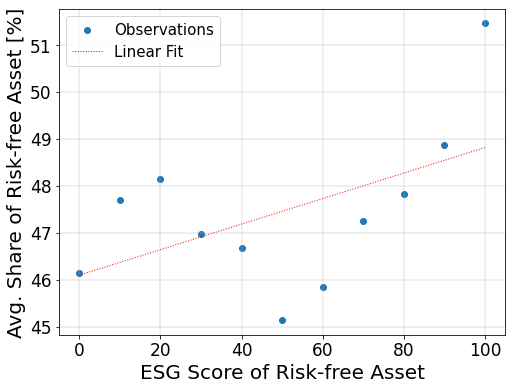

In [679]:
font = {'size': 20}

ESG_scores_List = [0,10,20,30,40,50,60,70,80,90,100]

#share_eff = []
share_risk_free = []

for dataframe in dataframes:
    #l = len(dataframe)
    k = sum(dataframe[dataframe['random_PF']==0]['share_rf'])
    x = len(dataframe[dataframe['random_PF']==0])
    share_risk_free.append(k/x*100)
    #dataframe[]
    
plt.figure(figsize=(8,6))
    
plt.scatter(ESG_scores_List, share_risk_free, label='Observations')#, linestyle='solid', label='Actual Data')

m, b = np.polyfit(ESG_scores_List,share_risk_free, 1)
esg_list = np.array(ESG_scores_List)
plt.plot(ESG_scores_List, m*esg_list+b, color='r', linewidth= 1,linestyle='dotted', label='Linear Fit')
labels = [str(0),str(20),str(40),str(60),str(round(ESG_Scores.mean(),2)),str(80),str(100)]
plt.grid(visible=True, linewidth=0.4)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
#plt.figure(figsize=(9,6))
plt.legend(prop={'size':15})
plt.xlabel('ESG Score of Risk-free Asset', fontdict=font)
plt.ylabel('Avg. Share of Risk-free Asset [%]',fontdict=font) #\n in overall portfolio
#plt.xticks(ticks=ESG_scores_List,labels=labels)
plt.savefig('share_rf_feb.png', dpi=300, bbox_inches='tight')
plt.show()

71.34794121372032


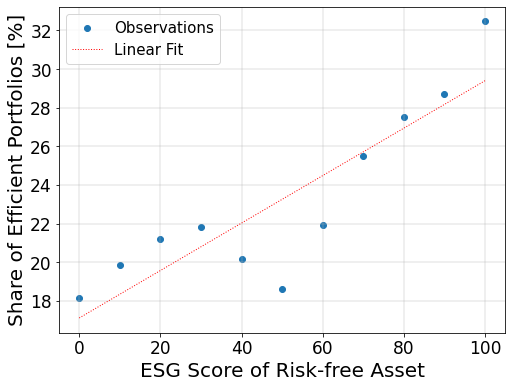

In [678]:
font = {'size': 20}

ESG_scores_List = [0,10,20,30,40,50,60,70,80,90,100]


print(ESG_Scores.mean())
share_eff = []
for dataframe in dataframes:
    l = len(dataframe)
    k = len(dataframe[dataframe['random_PF']==0])
    share_eff.append(k/l*100)
    #dataframe[]
    
    
plt.figure(figsize=(8,6))
#labels = [str(0),str(20),str(40),str(60),str(round(ESG_Scores.mean(),2)),str(80),str(100)]
plt.scatter(ESG_scores_List, share_eff, label='Observations')

x, y = np.polyfit(ESG_scores_List,share_eff, 1)
esg_list = np.array(ESG_scores_List)
plt.plot(ESG_scores_List, x*esg_list+y, color='r', linewidth= 1,linestyle='dotted', label='Linear Fit')
plt.grid(visible=True, linewidth=0.4)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(prop={'size':15})
plt.xlabel('ESG Score of Risk-free Asset', fontdict=font)
plt.ylabel('Share of Efficient Portfolios [%]',fontdict=font)
#plt.xticks(ticks=ESG_scores_List,labels=labels)
plt.savefig('share_eff_feb.png', dpi=300, bbox_inches='tight')
plt.show()

In [614]:
stats.pearsonr(ESG_scores_List, share_risk_free)

(0.5275181736970799, 0.09538259696683797)

In [646]:
opt_results

,index,std_dev,return,ESG,weights,random_PF
0,272,0.458355,1.223204,6.790925,"[1.0065290467690871e-13, 1.0914636054768383e-1...",1
1,273,0.456047,1.226374,6.790925,"[2.5178002435125935e-13, 2.408110201750646e-13...",1
2,274,0.456483,1.229788,6.790925,"[1.0560934213262875e-12, 1.0073169244054119e-1...",1
3,472,0.447479,1.223204,7.228635,"[9.286672328428152e-13, 1.0686153825447811e-12...",1
4,473,0.446177,1.226374,7.228635,"[7.141776563693323e-13, 6.820448752691792e-13,...",1
...,...,...,...,...,...,...
27100,39699,0.192304,1.315156,93.001123,"[6.662101869153047e-12, 1.1293764472027148e-11...",0
27101,39700,0.194816,1.31857,93.001123,"[7.647429597245509e-11, 1.2967608074410833e-10...",0
27102,39701,0.197503,1.321985,93.001123,"[1.528871698578398e-12, 1.6707719574252842e-12...",0
27103,39702,0.200358,1.3254,93.001123,"[2.895782445425146e-13, 3.1264833877549083e-13...",0


In [660]:
rf['ESG'].mean()

75.9458632930211

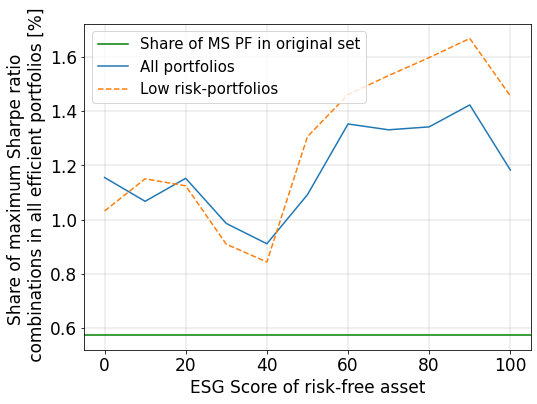

In [659]:
font = {'size': 17}

ESG_scores_List = [0,10,20,30,40,50,60,70,80,90,100]

#share_eff = []
share_sharp = []
share_sharp_min = []

for dataframe in dataframes:
    #l = len(dataframe)
    k = dataframe[dataframe['random_PF']==0]
    w = len(k[k['max_sharp']==2])
    x = len(k)
    
    
    u = k[k['std_dev']<0.07045645528153364]
    #if u != 0:
    q = len(u[u['max_sharp']==2])
    #print(datafram.name)
    share_sharp_min.append(q/len(u)*100)
    
    share_sharp.append(w/x*100)
    #share_sharp_min.append(q/u)
    #dataframe[]
    
plt.figure(figsize=(8,6))

#0.074
plt.axhline(y=0.5736, color='green', linestyle='-', label='Share of MS PF in original set')
plt.plot(ESG_scores_List, share_sharp, linestyle='solid', label='All portfolios')
plt.plot(ESG_scores_List, share_sharp_min, linestyle='dashed', label='Low risk-portfolios')

plt.grid(visible=True, linewidth=0.4)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
#plt.figure(figsize=(9,6))
plt.xlabel('ESG Score of risk-free asset', fontdict=font)
plt.ylabel('Share of maximum Sharpe ratio \n combinations in all efficient portfolios [%]', fontdict=font)

#Share of portfolios which are a linear combination \n of maximum sharp ratio portfolio in all efficient \n portfolios
plt.legend(prop={'size':15},  loc='upper left')
plt.savefig('share_sharp_feb.png', dpi=300, bbox_inches='tight')
plt.show()

# Trans analysis

In [235]:
df_trans

,returns,ESG,transparency,real_return
SHW,1.284286,79.468152,0.595213,28.428564
DTE,1.158350,82.844435,0.582726,15.835033
LOW,1.307411,84.502956,0.551509,30.741147
WBA,1.108031,90.328708,0.592092,10.803119
MAR,1.232468,75.380882,0.586889,23.246769
...,...,...,...,...
CI,1.216476,80.429496,0.560874,21.647567
FIS,1.195085,69.776147,0.534860,19.508458
FTNT,1.372760,63.542255,0.500520,37.276004
TXN,1.241377,85.689298,0.571280,24.137660


In [419]:
mus = np.array(df_trans['returns'])
len(mus)




379

In [420]:
sigma = (ret_trans.cov()*12).to_numpy()
len(sigma)

379

In [421]:
ESG_Scores = np.array(df_trans['ESG'].round(5))
len(ESG_Scores)

379

In [422]:
print(len(returns_range))
print(len(ESG_range))
max_ = (len(ESG_range))*(len(returns_range))
print(max_)
counter = 0
efficients = []
weights = []
num_assets = len(mus)
bounds = tuple((0,1) for asset in range(num_assets))
init_guess = num_assets*[1/num_assets]

i = (-1)
frontier = np.empty((4,0))

for target_E in tqdm(ESG_range):
    for target_return in returns_range:
        i = i + 1
        try:
            env = gp.Env(empty=True)
            env.setParam("OutputFlag",0)
            env.start()
            m = gp.Model("mip1", env=env)
            #m = gp.Model("test")
            
            #x = m.addVar(len(mus), lb=-1000, up=1000)
            x = m.addMVar(len(mus),lb=0)
            #x = m.addMVar(len(mus))

            portfolio_return = np.array(mus) @ x

            portfolio_esg = x @ ESG_Scores

            portfolio_risk = x @ sigma @ x

            m.setObjective(portfolio_risk, GRB.MINIMIZE)


            # Fix budget with a constraint
            m.addConstr(x.sum() == 1, 'budget')
            
            # return constraint
            m.addConstr(portfolio_return >= 0.9999*target_return)
            m.addConstr(portfolio_return <= 1.0001*target_return)

            # esg constraint
            m.addConstr(portfolio_esg >= 0.9999*target_E)
            m.addConstr(portfolio_esg <= 1.0001*target_E)

            # Optimize model to find the minimum risk portfolio
            m.optimize()

            #print(portfolio_esg)
            
            res_weights = x.X
            res_weights = np.array(res_weights)
            
            frontier = np.append(frontier, [[sqrt(m.ObjVal)],[np.dot(res_weights,np.array(mus))],[np.dot(res_weights,ESG_Scores)],[res_weights]], axis=1)
            
            
        except:
            frontier = np.append(frontier, [[np.nan],[target_return],[target_E],[np.nan]], axis=1)
            pass

200
200
40000


  0%|          | 0/200 [00:00<?, ?it/s]

In [423]:
a = []
for i in range(frontier.shape[1]):
    a.append(0)


df_trans_work = pd.DataFrame(frontier)   #, columns = ['Column_A','Column_B','Column_
df_trans_work = df_trans_work.transpose()
df_trans_work = df_trans_work.set_axis(['std_dev', 'return', 'ESG','weights'], axis=1)
df_trans_work['random_PF']= a
print(df_trans_work['std_dev'].isna().sum())
df_trans_work




15972


,std_dev,return,ESG,weights,random_PF
0,NaN,0.977199,6.35258,NaN,0
1,NaN,0.980614,6.35258,NaN,0
2,NaN,0.984029,6.35258,NaN,0
3,NaN,0.987444,6.35258,NaN,0
4,NaN,0.990859,6.35258,NaN,0
...,...,...,...,...,...
39995,NaN,1.643131,93.44809,NaN,0
39996,NaN,1.646546,93.44809,NaN,0
39997,NaN,1.649961,93.44809,NaN,0
39998,NaN,1.653376,93.44809,NaN,0


In [435]:
df_trans_work

,std_dev,return,ESG,weights,random_PF
0,NaN,0.977199,6.35258,NaN,0
1,NaN,0.980614,6.35258,NaN,0
2,NaN,0.984029,6.35258,NaN,0
3,NaN,0.987444,6.35258,NaN,0
4,NaN,0.990859,6.35258,NaN,0
...,...,...,...,...,...
39995,NaN,1.643131,93.44809,NaN,0
39996,NaN,1.646546,93.44809,NaN,0
39997,NaN,1.649961,93.44809,NaN,0
39998,NaN,1.653376,93.44809,NaN,0


In [241]:
df_trans_full_save = df_trans_work
df_trans_full_save

,std_dev,return,ESG,weights,random_PF
0,NaN,0.977199,6.35258,NaN,0
1,NaN,0.980614,6.35258,NaN,0
2,NaN,0.984029,6.35258,NaN,0
3,NaN,0.987444,6.35258,NaN,0
4,NaN,0.990859,6.35258,NaN,0
...,...,...,...,...,...
39995,NaN,1.643131,93.44809,NaN,0
39996,NaN,1.646546,93.44809,NaN,0
39997,NaN,1.649961,93.44809,NaN,0
39998,NaN,1.653376,93.44809,NaN,0


In [324]:
df_trans_work['diff_abs']= df_trans_work['std_dev']-df['std_dev']
#df_trans['diff_abs']= df_trans['std_dev']-df['std_dev']
df_trans_work['std_compare'] = df['std_dev']
df_trans_work

,std_dev,return,ESG,weights,random_PF,diff_abs,std_compare
0,NaN,0.977199,6.35258,NaN,0,NaN,NaN
1,NaN,0.980614,6.35258,NaN,0,NaN,NaN
2,NaN,0.984029,6.35258,NaN,0,NaN,NaN
3,NaN,0.987444,6.35258,NaN,0,NaN,NaN
4,NaN,0.990859,6.35258,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...
39995,NaN,1.643131,93.44809,NaN,0,NaN,NaN
39996,NaN,1.646546,93.44809,NaN,0,NaN,NaN
39997,NaN,1.649961,93.44809,NaN,0,NaN,NaN
39998,NaN,1.653376,93.44809,NaN,0,NaN,NaN


In [358]:
df_trans_full_save

,index,std_dev,return,ESG,weights,random_PF,diff_abs,std_compare
0,10057,0.267548,1.171973,28.238698,"[1.2635162839684333e-14, 2.152993048436313e-14...",1,0.148757,0.118791
1,10058,0.26564,1.175388,28.238698,"[5.770539043994846e-14, 5.732690453175013e-14,...",1,0.147809,0.117831
2,10059,0.263815,1.178804,28.238698,"[1.4846211732793743e-12, 1.3686369307340402e-1...",1,0.146663,0.117152
3,10060,0.262073,1.182219,28.238698,"[2.9846309542023345e-14, 3.1116874099515136e-1...",1,0.14544,0.116633
4,10061,0.260417,1.185635,28.238698,"[1.0830017637456095e-12, 1.0963568187155221e-1...",1,0.144159,0.116258
...,...,...,...,...,...,...,...,...
24022,39699,0.192304,1.315156,93.001123,"[4.3993099002521806e-10, 6.811807590079821e-10...",0,0.0,0.192304
24023,39700,0.194816,1.31857,93.001123,"[2.9756467975759277e-13, 4.461296229863904e-13...",0,-0.0,0.194816
24024,39701,0.197503,1.321985,93.001123,"[2.997541654723418e-12, 3.406168031651138e-12,...",0,0.0,0.197503
24025,39702,0.200358,1.3254,93.001123,"[9.828596096724656e-12, 1.833276164478058e-11,...",0,0.0,0.200358


In [325]:
df_trans_complete = df_trans_work
df_trans_complete

,std_dev,return,ESG,weights,random_PF,diff_abs,std_compare
0,NaN,0.977199,6.35258,NaN,0,NaN,NaN
1,NaN,0.980614,6.35258,NaN,0,NaN,NaN
2,NaN,0.984029,6.35258,NaN,0,NaN,NaN
3,NaN,0.987444,6.35258,NaN,0,NaN,NaN
4,NaN,0.990859,6.35258,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...
39995,NaN,1.643131,93.44809,NaN,0,NaN,NaN
39996,NaN,1.646546,93.44809,NaN,0,NaN,NaN
39997,NaN,1.649961,93.44809,NaN,0,NaN,NaN
39998,NaN,1.653376,93.44809,NaN,0,NaN,NaN


In [354]:
df_complete

,std_dev,return,ESG,weights,random_PF,uncorr. std
272,0.458355,1.223204,6.790925,"[1.0065290467690871e-13, 1.0914636054768383e-1...",0,0.461308
273,0.456047,1.226374,6.790925,"[2.5178002435125935e-13, 2.408110201750646e-13...",0,0.461362
274,0.456483,1.229788,6.790925,"[1.0560934213262875e-12, 1.0073169244054119e-1...",0,0.464993
472,0.447479,1.223204,7.228635,"[9.286672328428152e-13, 1.0686153825447811e-12...",0,0.454084
473,0.446177,1.226374,7.228635,"[7.141776563693323e-13, 6.820448752691792e-13,...",0,0.455366
...,...,...,...,...,...,...
39699,0.192304,1.315156,93.001123,"[6.662101869153047e-12, 1.1293764472027148e-11...",0,0.207579
39700,0.194816,1.31857,93.001123,"[7.647429597245509e-11, 1.2967608074410833e-10...",0,0.207908
39701,0.197503,1.321985,93.001123,"[1.528871698578398e-12, 1.6707719574252842e-12...",0,0.208238
39702,0.200358,1.3254,93.001123,"[2.895782445425146e-13, 3.1264833877549083e-13...",0,0.208567


In [438]:
df_trans_work['success all']= df_save_all['std_dev'].isna()
print(df_trans_work['std_dev'].isna().sum())
df_trans_work['diff']=df_trans_work['std_dev']-df_save_all['std_dev']
df_trans_work['perc_change']=df_trans_work['diff']/df_save_all['std_dev']
df_trans_work['Loss by trans']=np.nan
df_trans_work['diff_check']=df_trans_work['std_dev'].isna()
for j in range(0,len(df_trans_work)):
    if (df_trans_work['success all'][j]==False) and (df_trans_work['diff_check'][j]==True):
        df_trans_work['Loss by trans'][j] = 1
    else:
        df_trans_work['Loss by trans'][j] = 0
        
df_trans_work

15972


,std_dev,return,ESG,weights,random_PF,success all,diff,perc_change,Loss by trans,diff_check
0,NaN,0.977199,6.35258,NaN,0,True,NaN,NaN,0.0,True
1,NaN,0.980614,6.35258,NaN,0,True,NaN,NaN,0.0,True
2,NaN,0.984029,6.35258,NaN,0,True,NaN,NaN,0.0,True
3,NaN,0.987444,6.35258,NaN,0,True,NaN,NaN,0.0,True
4,NaN,0.990859,6.35258,NaN,0,True,NaN,NaN,0.0,True
...,...,...,...,...,...,...,...,...,...,...
39995,NaN,1.643131,93.44809,NaN,0,True,NaN,NaN,0.0,True
39996,NaN,1.646546,93.44809,NaN,0,True,NaN,NaN,0.0,True
39997,NaN,1.649961,93.44809,NaN,0,True,NaN,NaN,0.0,True
39998,NaN,1.653376,93.44809,NaN,0,True,NaN,NaN,0.0,True


In [439]:
df_trans_work_safe = df_trans_work.copy()
df_trans_work_safe

,std_dev,return,ESG,weights,random_PF,success all,diff,perc_change,Loss by trans,diff_check
0,NaN,0.977199,6.35258,NaN,0,True,NaN,NaN,0.0,True
1,NaN,0.980614,6.35258,NaN,0,True,NaN,NaN,0.0,True
2,NaN,0.984029,6.35258,NaN,0,True,NaN,NaN,0.0,True
3,NaN,0.987444,6.35258,NaN,0,True,NaN,NaN,0.0,True
4,NaN,0.990859,6.35258,NaN,0,True,NaN,NaN,0.0,True
...,...,...,...,...,...,...,...,...,...,...
39995,NaN,1.643131,93.44809,NaN,0,True,NaN,NaN,0.0,True
39996,NaN,1.646546,93.44809,NaN,0,True,NaN,NaN,0.0,True
39997,NaN,1.649961,93.44809,NaN,0,True,NaN,NaN,0.0,True
39998,NaN,1.653376,93.44809,NaN,0,True,NaN,NaN,0.0,True


In [326]:
df_trans_work.dropna(inplace=True )
df_trans_work

,std_dev,return,ESG,weights,random_PF,diff_abs,std_compare
10057,0.267548,1.171973,28.238698,"[1.2635162839684333e-14, 2.152993048436313e-14...",0,0.148757,0.118791
10058,0.26564,1.175388,28.238698,"[5.770539043994846e-14, 5.732690453175013e-14,...",0,0.147809,0.117831
10059,0.263815,1.178804,28.238698,"[1.4846211732793743e-12, 1.3686369307340402e-1...",0,0.146663,0.117152
10060,0.262073,1.182219,28.238698,"[2.9846309542023345e-14, 3.1116874099515136e-1...",0,0.14544,0.116633
10061,0.260417,1.185635,28.238698,"[1.0830017637456095e-12, 1.0963568187155221e-1...",0,0.144159,0.116258
...,...,...,...,...,...,...,...
39699,0.192304,1.315156,93.001123,"[4.3993099002521806e-10, 6.811807590079821e-10...",0,0.0,0.192304
39700,0.194816,1.31857,93.001123,"[2.9756467975759277e-13, 4.461296229863904e-13...",0,-0.0,0.194816
39701,0.197503,1.321985,93.001123,"[2.997541654723418e-12, 3.406168031651138e-12,...",0,0.0,0.197503
39702,0.200358,1.3254,93.001123,"[9.828596096724656e-12, 1.833276164478058e-11,...",0,0.0,0.200358


In [328]:
df_trans_work.reset_index(inplace=True)

In [103]:
import scipy.stats as stats

In [104]:
stats.ttest_rel(df_trans['std_dev'], df_trans['std_compare'])

Ttest_relResult(statistic=109.96184724117482, pvalue=0.0)

In [329]:
opt_results_trans = df_trans_work

for j in tqdm(range(0, len(opt_results_trans))):
    portfolio_std_dev = opt_results_trans["std_dev"][j]
    portfolio_return = opt_results_trans["return"][j]
    portfolio_ESG = opt_results_trans["ESG"][j]
    
    #for k in range(opt_results.min(), len(opt_results)):
    for k in range(0, len(opt_results_trans)):
        if k == j:
            continue
        elif opt_results_trans['random_PF'][k] == 1:
            continue
        else: 
            pf_std_dev_compare = opt_results_trans["std_dev"][k]
            pf_return_compare = opt_results_trans["return"][k]
            pf_ESG_compare = opt_results_trans["ESG"][k]
            if (pf_std_dev_compare <= portfolio_std_dev):
                if (pf_return_compare >= portfolio_return):
                    if (pf_ESG_compare >= portfolio_ESG):
                        opt_results_trans['random_PF'][j] = 1
                        break
                        
                        
                        
                        
                        
                        

  0%|          | 0/24027 [00:00<?, ?it/s]

In [111]:
ttest = opt_results_trans[opt_results_trans['random_PF']==0]
ttest

stats.ttest_rel(ttest['std_dev'], ttest['std_compare'])

Ttest_relResult(statistic=58.68884512470466, pvalue=0.0)

In [112]:
ttest['std_dev'].mean()

0.14992581250978154

In [113]:
ttest['std_compare'].mean()

0.1481344489529188

In [114]:
print(opt_results_trans['std_dev'].mean())
print(opt_results_trans['std_compare'].mean())

0.16567870312560573
0.14814303542565105


In [121]:
stats.wilcoxon(ttest['std_dev'], ttest['std_compare'])




WilcoxonResult(statistic=1162649.0, pvalue=0.0)

In [126]:
stats.wilcoxon(x = np.array([6,1,1,1.0000000001]), y=np.array([1,1,1,1]))



WilcoxonResult(statistic=0.0, pvalue=0.17971249487899976)

In [350]:
dom_normal = opt_results_adj
dom_trans = opt_results_trans[opt_results_trans['random_PF']==0]
dom_trans['Trans ON']=1
dom_normal['Trans ON']=0
dom_normal
frames = [dom_trans, dom_normal]
trans_and_normal = pd.concat(frames)
trans_and_normal

,index,std_dev,return,ESG,weights,random_PF,diff_abs,std_compare,Trans ON,uncorr. std,red. by div.,max_weight
8449,21399,0.499918,1.656625,52.750438,"[2.865323425774981e-14, 2.0986537322732847e-14...",0,0.000098,0.49982,1,NaN,NaN,NaN
9538,22598,0.448189,1.653211,55.376696,"[5.046392271334508e-13, 3.709348607198951e-13,...",0,0.002416,0.445773,1,NaN,NaN,NaN
9721,22798,0.443082,1.653211,55.814405,"[2.4070854222637073e-14, 1.770746898744959e-14...",0,0.002137,0.440945,1,NaN,NaN,NaN
10089,23198,0.433113,1.653211,56.689825,"[1.2288492271861244e-14, 9.120679689563816e-15...",0,0.00153,0.431584,1,NaN,NaN,NaN
10643,23798,0.418817,1.653211,58.002953,"[1.5540400712697423e-12, 1.143822599699745e-12...",0,0.00049,0.418327,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
27100,39699,0.192304,1.315156,93.001123,"[6.662101869153047e-12, 1.1293764472027148e-11...",0,NaN,NaN,0,0.207579,0.073584,0.916298
27101,39700,0.194816,1.31857,93.001123,"[7.647429597245509e-11, 1.2967608074410833e-10...",0,NaN,NaN,0,0.207908,0.062971,0.929992
27102,39701,0.197503,1.321985,93.001123,"[1.528871698578398e-12, 1.6707719574252842e-12...",0,NaN,NaN,0,0.208238,0.05155,0.943686
27103,39702,0.200358,1.3254,93.001123,"[2.895782445425146e-13, 3.1264833877549083e-13...",0,NaN,NaN,0,0.208567,0.039359,0.957380


[<matplotlib.lines.Line2D object at 0x7fa92819fe80>, <matplotlib.lines.Line2D object at 0x7fa92819f6d0>]


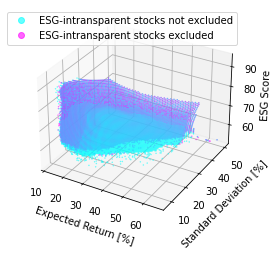

In [352]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

y=trans_and_normal['std_dev']*100
x=trans_and_normal['return']*100-100 
z=trans_and_normal['ESG']

#ax.scatter(x, y, z, c=sin_and_normal['Sin excluded'],cmap= 'cool', marker='.', alpha = 0.7, s=0.95)


sc = ax.scatter(x, y, z, c=trans_and_normal['Trans ON'],cmap= 'cool', marker='.', alpha = 0.6, s=0.9)

ax.set_xlabel('Expected Return [%]')
ax.set_ylabel('Standard Deviation [%]')
ax.set_zlabel('ESG Score')
ax.zaxis.labelpad=1.5

#fig.tight_layout()



plt.rcParams.update({'font.size': 10})
plt.rc('axes', labelsize = 10)

#ax.legend()
#legend1 = ax.legend([opt_results['random_PF']==0, opt_results['random_PF']==1],['Dominated Portfolios','Efficient Portfolios'], title="Legend")

#ax.add_artist(legend1)

#fig.tight_layout()
#plt.savefig('3D_frontier_eff_legend', dpi=300, bbox_inches='tight')
#plt.savefig('3D_frontier_eff.png')
print(sc.legend_elements()[0])

plt.legend([*sc.legend_elements()[0],*sc.legend_elements()[0]], ['ESG-intransparent stocks not excluded', 'ESG-intransparent stocks excluded'])
plt.savefig('3D_frontier_trans_compare_feb', dpi=300, bbox_inches='tight')
plt.show()

In [359]:
opt_results_trans

,index,std_dev,return,ESG,weights,random_PF,diff_abs,std_compare
0,10057,0.267548,1.171973,28.238698,"[1.2635162839684333e-14, 2.152993048436313e-14...",1,0.148757,0.118791
1,10058,0.26564,1.175388,28.238698,"[5.770539043994846e-14, 5.732690453175013e-14,...",1,0.147809,0.117831
2,10059,0.263815,1.178804,28.238698,"[1.4846211732793743e-12, 1.3686369307340402e-1...",1,0.146663,0.117152
3,10060,0.262073,1.182219,28.238698,"[2.9846309542023345e-14, 3.1116874099515136e-1...",1,0.14544,0.116633
4,10061,0.260417,1.185635,28.238698,"[1.0830017637456095e-12, 1.0963568187155221e-1...",1,0.144159,0.116258
...,...,...,...,...,...,...,...,...
24022,39699,0.192304,1.315156,93.001123,"[4.3993099002521806e-10, 6.811807590079821e-10...",0,0.0,0.192304
24023,39700,0.194816,1.31857,93.001123,"[2.9756467975759277e-13, 4.461296229863904e-13...",0,-0.0,0.194816
24024,39701,0.197503,1.321985,93.001123,"[2.997541654723418e-12, 3.406168031651138e-12,...",0,0.0,0.197503
24025,39702,0.200358,1.3254,93.001123,"[9.828596096724656e-12, 1.833276164478058e-11,...",0,0.0,0.200358


In [378]:
opt_results_trans['perc_change'] = opt_results_trans['diff_abs']/opt_results_trans['std_compare']
opt_results_trans['perc_change'].min()

-5.954652748456162e-07

In [360]:
opt_res_trans_2 = opt_results_trans[opt_results_trans['random_PF']==0]

In [363]:
opt_res_trans_2['perc_change'] = opt_res_trans_2['diff_abs']/opt_res_trans_2['std_compare']
opt_res_trans_2

,index,std_dev,return,ESG,weights,random_PF,diff_abs,std_compare,perc_change
8449,21399,0.499918,1.656625,52.750438,"[2.865323425774981e-14, 2.0986537322732847e-14...",0,0.000098,0.49982,0.000197
9538,22598,0.448189,1.653211,55.376696,"[5.046392271334508e-13, 3.709348607198951e-13,...",0,0.002416,0.445773,0.00542
9721,22798,0.443082,1.653211,55.814405,"[2.4070854222637073e-14, 1.770746898744959e-14...",0,0.002137,0.440945,0.004847
10089,23198,0.433113,1.653211,56.689825,"[1.2288492271861244e-14, 9.120679689563816e-15...",0,0.00153,0.431584,0.003545
10643,23798,0.418817,1.653211,58.002953,"[1.5540400712697423e-12, 1.143822599699745e-12...",0,0.00049,0.418327,0.001172
...,...,...,...,...,...,...,...,...,...
24022,39699,0.192304,1.315156,93.001123,"[4.3993099002521806e-10, 6.811807590079821e-10...",0,0.0,0.192304,0.0
24023,39700,0.194816,1.31857,93.001123,"[2.9756467975759277e-13, 4.461296229863904e-13...",0,-0.0,0.194816,-0.0
24024,39701,0.197503,1.321985,93.001123,"[2.997541654723418e-12, 3.406168031651138e-12,...",0,0.0,0.197503,0.0
24025,39702,0.200358,1.3254,93.001123,"[9.828596096724656e-12, 1.833276164478058e-11,...",0,0.0,0.200358,0.0


In [385]:
opt_res_trans_2['perc_change'].median()

0.0043462907176746585

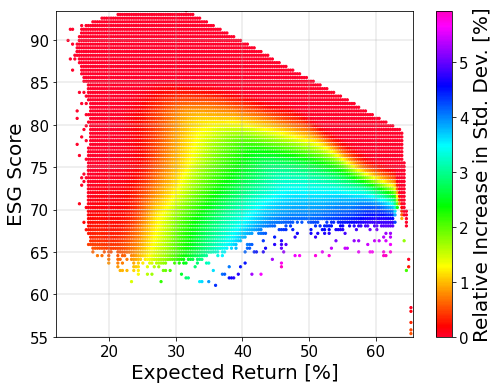

In [367]:
plt.rcParams.update({'font.size': 15})
plt.rc('axes', labelsize = 20)
plt.figure(figsize=(8, 6))
plt.scatter(opt_res_trans_2['return']*100-100,opt_res_trans_2['ESG'], c = opt_res_trans_2['perc_change']*100, cmap= 'gist_rainbow', marker='o',s=5, alpha=1.0, label = 'Inefficient PF') #, label = solve_notsolve['solve'])
plt.colorbar(label='Relative Increase in Std. Dev. [%]')
plt.ylabel('ESG Score')
plt.xlabel('Expected Return [%]')
#plt.legend(['std. dev.'])
plt.xlim(12, max(mus)*100-100)
#plt.ylim(min(ESG_Scores), max(ESG_Scores))
plt.ylim(55, max(ESG_Scores))

plt.grid(visible=True, linewidth=0.4)
#plt.savefig('2D_trans_complete_overview.png', dpi=300)
#plt.legend(markerscale=4, fontsize=14)
#plt.savefig('2D_eff_thesis.png')
plt.savefig('2D_trans_relative_increase_feb.png', dpi=300)
#plt.savefig('2d_trans_eff_rel.png', dpi=300)
plt.show()

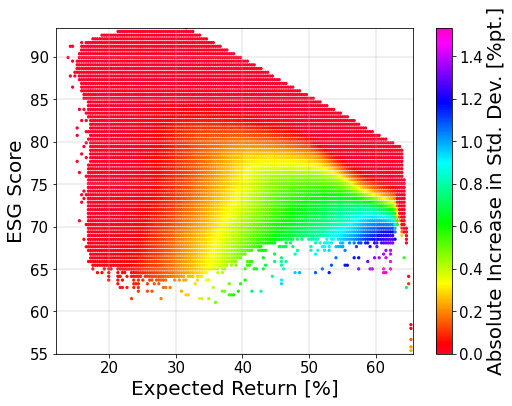

In [369]:
plt.rcParams.update({'font.size': 15})
plt.rc('axes', labelsize = 20)
plt.figure(figsize=(8, 6))
plt.scatter(opt_res_trans_2['return']*100-100,opt_res_trans_2['ESG'], c = opt_res_trans_2['diff_abs']*100, cmap= 'gist_rainbow', marker='o',s=5, alpha=1.0, label = 'Inefficient PF') #, label = solve_notsolve['solve'])
plt.colorbar(label='Absolute Increase in Std. Dev. [%pt.]')
plt.ylabel('ESG Score')
plt.xlabel('Expected Return [%]')
#plt.legend(['std. dev.'])
plt.xlim(12, max(mus)*100-100)
#plt.ylim(min(ESG_Scores), max(ESG_Scores))
plt.ylim(55, max(ESG_Scores))

plt.grid(visible=True, linewidth=0.4)
#plt.savefig('2D_trans_complete_overview.png', dpi=300)
#plt.legend(markerscale=4, fontsize=14)
#plt.savefig('2D_eff_thesis.png')
plt.savefig('2D_trans_absolute_increase_feb.png', dpi=300)
#plt.savefig('2d_trans_eff_rel.png', dpi=300)
plt.show()

In [442]:
df_trans_work_2 = df_trans_work.dropna()
df_trans_work_2

,std_dev,return,ESG,weights,random_PF,success all,diff,perc_change,Loss by trans,diff_check
10057,0.267548,1.171973,28.238698,"[1.2635162839684333e-14, 2.152993048436313e-14...",0,False,0.148757,1.252254,0.0,False
10058,0.26564,1.175388,28.238698,"[5.770539043994846e-14, 5.732690453175013e-14,...",0,False,0.147809,1.254415,0.0,False
10059,0.263815,1.178804,28.238698,"[1.4846211732793743e-12, 1.3686369307340402e-1...",0,False,0.146663,1.251901,0.0,False
10060,0.262073,1.182219,28.238698,"[2.9846309542023345e-14, 3.1116874099515136e-1...",0,False,0.14544,1.246982,0.0,False
10061,0.260417,1.185635,28.238698,"[1.0830017637456095e-12, 1.0963568187155221e-1...",0,False,0.144159,1.239987,0.0,False
...,...,...,...,...,...,...,...,...,...,...
39699,0.192304,1.315156,93.001123,"[4.3993099002521806e-10, 6.811807590079821e-10...",0,False,0.0,0.0,0.0,False
39700,0.194816,1.31857,93.001123,"[2.9756467975759277e-13, 4.461296229863904e-13...",0,False,-0.0,-0.0,0.0,False
39701,0.197503,1.321985,93.001123,"[2.997541654723418e-12, 3.406168031651138e-12,...",0,False,0.0,0.0,0.0,False
39702,0.200358,1.3254,93.001123,"[9.828596096724656e-12, 1.833276164478058e-11,...",0,False,0.0,0.0,0.0,False


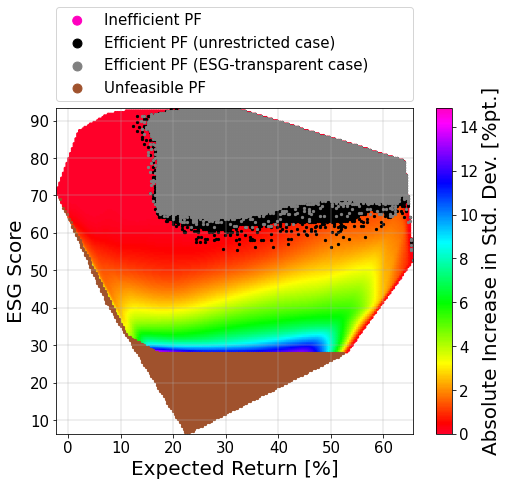

In [445]:
plt.figure(figsize=(8, 6))
#plt.scatter(opt_res_trans_2['return'],opt_res_trans_2['ESG'], c = opt_res_trans_2['perc_change'], cmap= 'gist_rainbow', marker='o',s=5, alpha=1.0) #, label = solve_notsolve['solve'])
plt.scatter(df_trans_work_2['return']*100-100,df_trans_work_2['ESG'], c= df_trans_work_2['diff']*100,cmap='gist_rainbow', marker='o',s=5, alpha=1.0, label='Inefficient PF')
plt.colorbar(label='Absolute Increase in Std. Dev. [%pt.]')
plt.scatter(opt_results_adj['return']*100-100,opt_results_adj['ESG'], c = 'black', cmap= 'gist_rainbow', marker='o',s=5, alpha=1.0, label='Efficient PF (unrestricted case)')
plt.scatter(opt_res_trans_2['return']*100-100,opt_res_trans_2['ESG'], c='gray', marker='o',s=5, alpha=1.0, label='Efficient PF (ESG-transparent case)')
plt.scatter(df_trans_work[df_trans_work['Loss by trans']==1]['return']*100-100,df_trans_work[df_trans_work['Loss by trans']==1]['ESG'], c='sienna', marker='o',s=5, alpha=1.0, label='Unfeasible PF')

plt.ylabel('ESG Score')
plt.xlabel('Expected Return [%]')

plt.legend(markerscale=4, bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",mode="expand", borderaxespad=0, ncol=1)
plt.xlim(min(mus)*100-100, max(mus)*100-100)
#plt.ylim(min(ESG_Scores), max(ESG_Scores))
plt.ylim(6.35, max(ESG_Scores))


plt.rcParams.update({'font.size': 15})
plt.rc('axes', labelsize = 20)

plt.grid(visible=True, linewidth=0.4)
plt.savefig('trans_complete_overview_feb.png', dpi=300, bbox_inches='tight')

#plt.savefig('2D_eff_thesis.png')
plt.show()

In [453]:
r = opt_res_trans_2[opt_res_trans_2['ESG']>80]
r['diff_abs'].mean()

0.00014874044176410028

In [178]:
rtz =opt_results_trans[opt_results_trans['random_PF']==0]
rtz = rtz[rtz['ESG']<75]
rtz = rtz[rtz['ESG']>70]

In [179]:
rtz

,index,std_dev,return,ESG,weights,random_PF,diff_abs,std_compare
4967,10547,0.076089,1.154896,70.682395,"[6.042734597515713e-10, 2.013460544766759e-09,...",0,0.000056,0.076032
5117,10752,0.077284,1.158311,72.870506,"[1.3724215315805789e-09, 4.65150210827429e-09,...",0,0.00002,0.077263
5119,10754,0.077947,1.158311,73.74575,"[2.866863774421102e-10, 1.0939028952555238e-09...",0,0.00001,0.077938
5264,10953,0.077539,1.161727,73.308128,"[1.4005455957935164e-09, 4.902955577179655e-09...",0,0.000017,0.077522
5266,10955,0.078242,1.161727,74.183372,"[1.3322717397226131e-09, 5.6323560742536095e-0...",0,0.000008,0.078234
...,...,...,...,...,...,...,...,...
23930,39152,0.323819,1.642966,72.870506,"[8.461348971255124e-12, 6.287431570131402e-12,...",0,0.0,0.323819
23931,39153,0.326838,1.642966,73.308128,"[4.638318185620746e-13, 3.009362398275889e-13,...",0,-0.0,0.326838
23932,39154,0.330167,1.642966,73.74575,"[3.031999551795551e-13, 1.792192136485654e-13,...",0,0.0,0.330167
23933,39155,0.333797,1.642966,74.183372,"[1.4788161137404548e-12, 9.61492805581968e-13,...",0,0.0,0.333797


In [392]:
opt_res_trans_3 = opt_res_trans_2[opt_res_trans_2['ESG']>86]
opt_res_trans_3

,index,std_dev,return,ESG,weights,random_PF,diff_abs,std_compare,perc_change
22451,36649,0.096402,1.14465,86.436791,"[8.782926244495666e-10, 3.2270923028407973e-09...",0,0.0,0.096402,0.0
22455,36653,0.096061,1.158311,86.436791,"[6.843146407855156e-11, 2.4993491634363275e-10...",0,0.0,0.096061,0.0
22456,36654,0.096074,1.161495,86.436791,"[5.411969698553461e-10, 1.8016635251906296e-09...",0,-0.0,0.096074,-0.0
22457,36655,0.096127,1.164909,86.436791,"[9.003326639645119e-10, 3.1588320302934796e-09...",0,0.0,0.096127,0.0
22458,36656,0.096218,1.168324,86.436791,"[1.4935126276048568e-12, 5.315530498120596e-12...",0,-0.0,0.096218,-0.0
...,...,...,...,...,...,...,...,...,...
24022,39699,0.192304,1.315156,93.001123,"[4.3993099002521806e-10, 6.811807590079821e-10...",0,0.0,0.192304,0.0
24023,39700,0.194816,1.31857,93.001123,"[2.9756467975759277e-13, 4.461296229863904e-13...",0,-0.0,0.194816,-0.0
24024,39701,0.197503,1.321985,93.001123,"[2.997541654723418e-12, 3.406168031651138e-12,...",0,0.0,0.197503,0.0
24025,39702,0.200358,1.3254,93.001123,"[9.828596096724656e-12, 1.833276164478058e-11,...",0,0.0,0.200358,0.0


In [393]:
stats.wilcoxon(opt_res_trans_3['std_dev'], opt_res_trans_3['std_compare'])

WilcoxonResult(statistic=314303.0, pvalue=0.20154600725168337)

# Map Stock weights



In [330]:
df

,std_dev,return,ESG,weights,random_PF
0,NaN,0.977199,6.35258,NaN,0
1,NaN,0.980614,6.35258,NaN,0
2,NaN,0.984029,6.35258,NaN,0
3,NaN,0.987444,6.35258,NaN,0
4,NaN,0.990859,6.35258,NaN,0
...,...,...,...,...,...
39995,NaN,1.643131,93.44809,NaN,0
39996,NaN,1.646546,93.44809,NaN,0
39997,NaN,1.649961,93.44809,NaN,0
39998,NaN,1.653376,93.44809,NaN,0


In [331]:
df['uncorr. std']= np.nan
#np.matmul(df['weights'], ((returns/100).std().to_numpy())*sqrt(12))
for j in range(0, len(df)):
    if isinstance(df['weights'][j], float) == False:
        df['uncorr. std'][j]=np.matmul(df['weights'][j], (ret.std().to_numpy())*sqrt(12))
    
df

,std_dev,return,ESG,weights,random_PF,uncorr. std
0,NaN,0.977199,6.35258,NaN,0,NaN
1,NaN,0.980614,6.35258,NaN,0,NaN
2,NaN,0.984029,6.35258,NaN,0,NaN
3,NaN,0.987444,6.35258,NaN,0,NaN
4,NaN,0.990859,6.35258,NaN,0,NaN
...,...,...,...,...,...,...
39995,NaN,1.643131,93.44809,NaN,0,NaN
39996,NaN,1.646546,93.44809,NaN,0,NaN
39997,NaN,1.649961,93.44809,NaN,0,NaN
39998,NaN,1.653376,93.44809,NaN,0,NaN


In [332]:
df[df['std_dev']==df['std_dev'].min()]

,std_dev,return,ESG,weights,random_PF,uncorr. std
26657,0.074212,1.171973,64.555686,"[1.8333478866027684e-11, 3.418893345342845e-11...",0,0.232683


In [200]:
df['red. by div.']=(df['std_dev']/df['uncorr. std']-1)*(-1)
df

,index,std_dev,return,ESG,weights,random_PF,uncorr. std,red. by div.
0,272,0.458355,1.223204,6.790925,"[1.0065290467690871e-13, 1.0914636054768383e-1...",1,0.461308,0.006401
1,273,0.456047,1.226374,6.790925,"[2.5178002435125935e-13, 2.408110201750646e-13...",1,0.461362,0.01152
2,274,0.456483,1.229788,6.790925,"[1.0560934213262875e-12, 1.0073169244054119e-1...",1,0.464993,0.018302
3,472,0.447479,1.223204,7.228635,"[9.286672328428152e-13, 1.0686153825447811e-12...",1,0.454084,0.014546
4,473,0.446177,1.226374,7.228635,"[7.141776563693323e-13, 6.820448752691792e-13,...",1,0.455366,0.02018
...,...,...,...,...,...,...,...,...
27100,39699,0.192304,1.315156,93.001123,"[6.662101869153047e-12, 1.1293764472027148e-11...",0,0.207579,0.073584
27101,39700,0.194816,1.31857,93.001123,"[7.647429597245509e-11, 1.2967608074410833e-10...",0,0.207908,0.062971
27102,39701,0.197503,1.321985,93.001123,"[1.528871698578398e-12, 1.6707719574252842e-12...",0,0.208238,0.05155
27103,39702,0.200358,1.3254,93.001123,"[2.895782445425146e-13, 3.1264833877549083e-13...",0,0.208567,0.039359


In [201]:
df['max_weight']=np.nan
for j in range(0,len(df)):
    df['max_weight'][j]=df['weights'][j].max()
df

,index,std_dev,return,ESG,weights,random_PF,uncorr. std,red. by div.,max_weight
0,272,0.458355,1.223204,6.790925,"[1.0065290467690871e-13, 1.0914636054768383e-1...",1,0.461308,0.006401,0.982601
1,273,0.456047,1.226374,6.790925,"[2.5178002435125935e-13, 2.408110201750646e-13...",1,0.461362,0.01152,0.978655
2,274,0.456483,1.229788,6.790925,"[1.0560934213262875e-12, 1.0073169244054119e-1...",1,0.464993,0.018302,0.979605
3,472,0.447479,1.223204,7.228635,"[9.286672328428152e-13, 1.0686153825447811e-12...",1,0.454084,0.014546,0.959088
4,473,0.446177,1.226374,7.228635,"[7.141776563693323e-13, 6.820448752691792e-13,...",1,0.455366,0.02018,0.956929
...,...,...,...,...,...,...,...,...,...
27100,39699,0.192304,1.315156,93.001123,"[6.662101869153047e-12, 1.1293764472027148e-11...",0,0.207579,0.073584,0.916298
27101,39700,0.194816,1.31857,93.001123,"[7.647429597245509e-11, 1.2967608074410833e-10...",0,0.207908,0.062971,0.929992
27102,39701,0.197503,1.321985,93.001123,"[1.528871698578398e-12, 1.6707719574252842e-12...",0,0.208238,0.05155,0.943686
27103,39702,0.200358,1.3254,93.001123,"[2.895782445425146e-13, 3.1264833877549083e-13...",0,0.208567,0.039359,0.957380


In [202]:
stats.pearsonr(df['red. by div.'], df['max_weight'])

(-0.9414582869014491, 0.0)

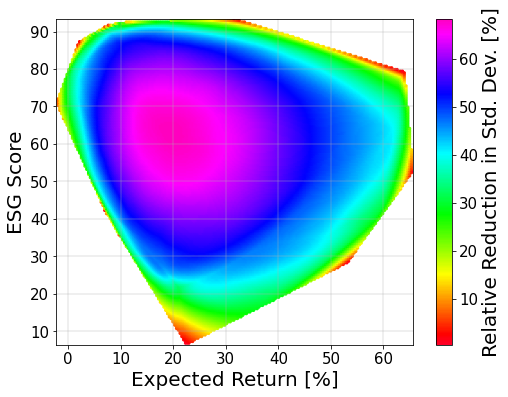

In [245]:
plt.figure(figsize=(8, 6))
plt.scatter(df['return']*100-100,df['ESG'], c = df['red. by div.']*100, cmap= 'gist_rainbow', marker='o',s=5, alpha=1.0) #, label = solve_notsolve['solve'])
plt.colorbar(label='Relative Reduction in Std. Dev. [%]')
#plt.scatter(sdp,rp,marker='*',color='r',s=300, label='Maximum Sharpe Ratio')
#plt.scatter(sdp_min,rp_min,marker='*',color='g',s=300, label='Minimum volatility')  gist_rainbow
#plt.title('')
plt.ylabel('ESG Score')
plt.xlabel('Expected Return [%]')
#plt.legend(['std. dev.'])

plt.rcParams.update({'font.size': 15})
plt.rc('axes', labelsize = 20)

plt.xlim(min(mus)*100-100, max(mus)*100-100)
plt.ylim(6.35, max(ESG_Scores))

plt.grid(visible=True, linewidth=0.4)
plt.savefig('Rel_risk_red_feb.png', dpi=300)
#plt.savefig('2D_eff_thesis.png')
plt.show()

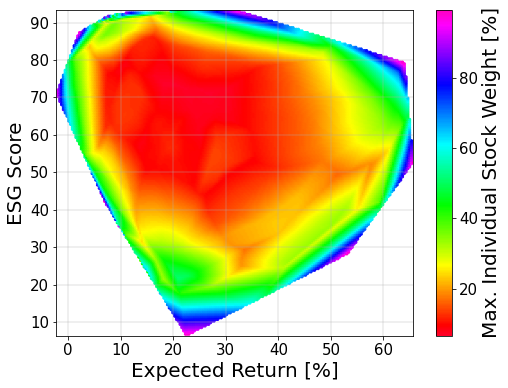

In [244]:
plt.figure(figsize=(8, 6))
plt.scatter(df['return']*100-100,df['ESG'], c = df['max_weight']*100, cmap= 'gist_rainbow', marker='o',s=5, alpha=1.0) #, label = solve_notsolve['solve'])
plt.colorbar(label='Max. Individual Stock Weight [%]')
#plt.scatter(sdp,rp,marker='*',color='r',s=300, label='Maximum Sharpe Ratio')
#plt.scatter(sdp_min,rp_min,marker='*',color='g',s=300, label='Minimum volatility')  gist_rainbow
#plt.title('')
plt.ylabel('ESG Score')
plt.xlabel('Expected Return [%]')
#plt.legend(['std. dev.'])

plt.rcParams.update({'font.size': 15})
plt.rc('axes', labelsize = 20)

plt.xlim(min(mus)*100-100, max(mus)*100-100)
plt.ylim(6.35, max(ESG_Scores))

plt.grid(visible=True, linewidth=0.4)
plt.savefig('Maximum_PF_weights_feb.png', dpi=300)
#plt.savefig('2D_eff_thesis.png')
plt.show()

# PF intervals

In [213]:
#list(df.index.values)

In [674]:
opt_results_adj = opt_results[opt_results['random_PF']==0]
ESG_min = opt_results_adj['ESG'].min()
ESG_max = opt_results_adj['ESG'].max()
return_min = opt_results_adj['return'].min()
return_max = opt_results_adj['return'].max()
std_dev_min = opt_results_adj['std_dev'].min()
std_dev_max = opt_results_adj['std_dev'].max()
list_ESG = []
list_return = []
list_std_dev = []
list_correlation = []
perc = []


for i in range(0,101):
    perc.append(i)
    a = opt_results_adj[opt_results_adj['ESG']>=(ESG_min+(i/100)*(ESG_max-ESG_min))]
    #list_x = a['new'].tolist()
    list_x = list(a.index.values)
    r = len(a)
    list_ESG.append(r)
    
    b = opt_results_adj[opt_results_adj['return']>=(return_min+(i/100)*(return_max-return_min))]
    #list_y = b['new'].tolist()
    list_y = list(b.index.values)
    s = len(b)
    list_return.append(s)
    
    c = opt_results_adj[opt_results_adj['std_dev']<=(std_dev_max-(i/100)*(std_dev_max-std_dev_min))]
    #list_z = c['new'].tolist()
    list_z = list(c.index.values)
    t = len(c)
    list_std_dev.append(t)
    
    common = set(list_x).intersection(list_y)
    common_2 = set(common).intersection(list_z)
    list_correlation.append(len(common_2))

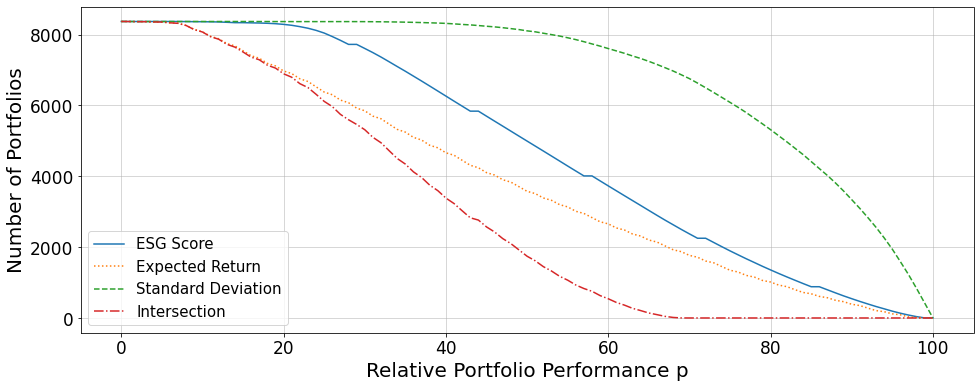

In [677]:
plt.figure(figsize=(16,6))
#font = {'family': 'sans-serif',
#        'weight': 'normal',
#        'size': 11,
#        }

font={'size':20}
#plt.rcParams.update({'font.size': 16})
#plt.rc('axes', labelsize = 16)

plt.plot(perc, list_ESG, linestyle='solid', label='ESG Score')
plt.plot(perc, list_return, linestyle='dotted', label='Expected Return')
plt.plot(perc, list_std_dev, linestyle='dashed', label = 'Standard Deviation')
plt.plot(perc, list_correlation, linestyle='dashdot', label='Intersection')
plt.legend(loc='lower left', prop={'size':15})
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.grid(visible=True, linewidth=0.5)

plt.xlabel('Relative Portfolio Performance p', fontdict=font)
plt.ylabel('Number of Portfolios',fontdict=font)
#plt.savefig('overview.svg', format='svg', dpi=1200)

plt.savefig('intersection_feb_new.png', dpi='figure', quality = 100, optimize = True)

#plt.savefig('overview_2.png', dpi=300, bbox_inches='tight')
plt.show()

# Sharp ratio analysis

In [254]:
df_2 = df
df_2

,index,std_dev,return,ESG,weights,random_PF,uncorr. std,red. by div.,max_weight
0,272,0.458355,1.223204,6.790925,"[1.0065290467690871e-13, 1.0914636054768383e-1...",1,0.461308,0.006401,0.982601
1,273,0.456047,1.226374,6.790925,"[2.5178002435125935e-13, 2.408110201750646e-13...",1,0.461362,0.01152,0.978655
2,274,0.456483,1.229788,6.790925,"[1.0560934213262875e-12, 1.0073169244054119e-1...",1,0.464993,0.018302,0.979605
3,472,0.447479,1.223204,7.228635,"[9.286672328428152e-13, 1.0686153825447811e-12...",1,0.454084,0.014546,0.959088
4,473,0.446177,1.226374,7.228635,"[7.141776563693323e-13, 6.820448752691792e-13,...",1,0.455366,0.02018,0.956929
...,...,...,...,...,...,...,...,...,...
27100,39699,0.192304,1.315156,93.001123,"[6.662101869153047e-12, 1.1293764472027148e-11...",0,0.207579,0.073584,0.916298
27101,39700,0.194816,1.31857,93.001123,"[7.647429597245509e-11, 1.2967608074410833e-10...",0,0.207908,0.062971,0.929992
27102,39701,0.197503,1.321985,93.001123,"[1.528871698578398e-12, 1.6707719574252842e-12...",0,0.208238,0.05155,0.943686
27103,39702,0.200358,1.3254,93.001123,"[2.895782445425146e-13, 3.1264833877549083e-13...",0,0.208567,0.039359,0.957380


In [258]:
df['ESG_groups'].unique()

[(6.704, 7.224], (7.224, 7.657], (7.657, 8.091], (8.091, 8.524], (8.524, 8.957], ..., (91.273, 91.706], (91.706, 92.139], (92.139, 92.572], (92.572, 93.006], (93.006, 93.439]]
Length: 199
Categories (200, interval[float64, right]): [(6.704, 7.224] < (7.224, 7.657] < (7.657, 8.091] < (8.091, 8.524] ... (91.706, 92.139] < (92.139, 92.572] < (92.572, 93.006] < (93.006, 93.439]]

In [301]:
df['random_PF'] = 0

In [289]:
len(ESG_range)

200

In [302]:
df['ESG_groups'] = pd.cut(df.ESG,100)
df['sharp_ratio'] = (df['return']-1)/df['std_dev']
sharps = []
for intervall in df['ESG_groups'].unique():
    #intervall = opt_results['ESG_groups'].unique()[0]
    p = df[df['ESG_groups']==intervall]
    #q = p[p['random_PF']==0]
    i = p[p['sharp_ratio']==p['sharp_ratio'].max()].index[0]
    sharps.append(i)
print(sharps)

for i in sharps:
    df['random_PF'][i] = 2

[7, 23, 49, 84, 129, 184, 247, 320, 403, 495, 595, 703, 817, 939, 1069, 1211, 1363, 1526, 1699, 1881, 2074, 2277, 2489, 2712, 2940, 3180, 3423, 3672, 3926, 4185, 4448, 4715, 4988, 5265, 5547, 5835, 6126, 6422, 6723, 7029, 7339, 7654, 7973, 8297, 8625, 8956, 9292, 9632, 9804, 10151, 10502, 10856, 11216, 11580, 11945, 12311, 12679, 13049, 13420, 13793, 14167, 14541, 14918, 15107, 15485, 15865, 16247, 16629, 17012, 17397, 17783, 18171, 18561, 18952, 19343, 19733, 20121, 20509, 20895, 21279, 21662, 22042, 22421, 22798, 23173, 23536, 23885, 24221, 24546, 24858, 25157, 25443, 25714, 25971, 26211, 26433, 26636, 26822, 26986, 27099]


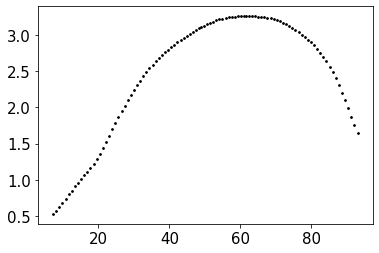

In [303]:
sr = df[df['random_PF']==2]
plt.scatter(sr['ESG'], sr['sharp_ratio'], c ='black', s =3.0)

plt.show()
#sr

In [293]:
tz =df[df['ESG_groups']==df['ESG_groups'].unique()[0]]
tz[tz['sharp_ratio']==tz['sharp_ratio'].max()].index[0]


7

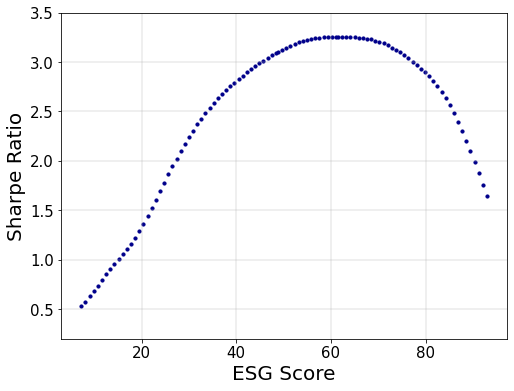

In [314]:
plt.figure(figsize=(8, 6))
#plt.scatter(, c = not_opt['std_dev']*100, cmap= 'gist_rainbow', marker='o',s=0.1, alpha=1.0, label='Efficient Portfolios') #, label = solve_notsolve['solve'])
#plt.colorbar(label='Standard Deviation [%]')
plt.scatter(sr['ESG'], sr['sharp_ratio'], c ='darkblue', s =10.0)

#plt.scatter(0.23957*100,62.38,marker='*',color='black',s=100, label='Minimum Variance Portfolio')

#plt.scatter(sdp_min,rp_min,marker='*',color='g',s=300, label='Minimum volatility')  gist_rainbow
#plt.title('')
plt.ylabel('Sharpe Ratio')
plt.xlabel('ESG Score')
#plt.legend(['std. dev.'])

plt.rcParams.update({'font.size': 15})
plt.rc('axes', labelsize = 20)

#plt.xlim(min(mus)*100, max(mus)*100)
plt.ylim(0.2, 3.5)

plt.grid(visible=True, linewidth=0.4)
#plt.legend(loc='lower right')
#plt.legend(bbox_to_anchor =(0.75, 1.15), markerscale=1, fontsize=15)
#plt.savefig('2D_all+eff_final.png', dpi=300)
plt.savefig('sharpe_feb.png')

plt.show()